In [56]:
import numpy as np
import pandas as pd
import collections as c
import pickle
import seaborn as sns
sns.reset_defaults
sns.set_style(style='darkgrid')

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 2000)

In [46]:
class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
        self.residuals_ = self.results_.outlier_test()['student_resid']
    def fit_regularized(self, X, y, a, l1):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit_regularized(alpha=a, L1_wt=l1)
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)
    def summary(self):
        return self.results_.summary()

In [47]:
lin_reg_model = pickle.load(open('../models/linear_regression_score_first_half.p', 'rb')) # load the model

In [48]:
# model = LinearRegression(n_jobs=-1)

In [49]:
def scale_subset(df, columns):
    '''
    Use sklearn StandardScalar to scale only numeric columns.

    Parameters:
    ----------
    input {dataframe, list}: dataframe containing mixed feature variable types, list of names of numeric feature columns
    output: {dataframe}: dataframe with numeric features scaled and categorical features unchanged

    '''
    scalar = StandardScaler()
    numeric = df[columns]
    categorical = df.drop(columns, axis = 1)
    scalar.fit(numeric)
    num_scaled = pd.DataFrame(scalar.transform(numeric))
    num_scaled.rename(columns = dict(zip(num_scaled.columns, numeric_cols)), inplace = True)
    return pd.concat([num_scaled, categorical], axis = 1)


def only_completed(X_test, y_test, y_test_not_comp):
    '''
    Returns dataframes with only those students who completed the course for the purpose of regressing the final score.
    '''
    test_indices = []
    train_indices = []

    y_test_not_comp = y_test_not_comp[y_test_not_comp['module_not_completed'] == 1]
    for index, row in y_test_not_comp.iterrows():
        test_indices.append(index)

    return X_test.drop(test_indices), y_test.drop(test_indices)

def plot_residuals(stud_resid, target, features, data):
    '''
    Creates scatterplots of residuals against target and specified features
    Parameters:
    ----------
    input {all array-like}: calculated residuals, target values from test data, list of features to plot against
    output {plots}: some plots
    '''
    plt.figure(figsize=(12,10))
    plt.scatter(x=target, y=stud_resid, alpha = 0.1, c='red')
    plt.hlines(0, target.min(), target.max(), 'k', linestyle='dashed')
    plt.ylabel("Residuals")
    plt.xlabel("Target")
    plt.title("Residuals vs. Target")
    plt.show()

    for f in features:
        plt.figure(figsize=(12,10))
        plt.scatter(x=data[f], y=stud_resid, alpha=0.1, c='blue')
        plt.hlines(0,
              data[f].min(), 
              data[f].max(), 
              'k', linestyle='dashed')
        plt.ylabel("Residuals")
        plt.xlabel(f)
        plt.title("Residuals vs {}".format(f))
        plt.show()

In [50]:
#     X_train = pd.read_csv('../data/processed/first_half/X_train.csv')
#     y_train = pd.read_csv('../data/processed/first_half/y_train.csv')
#     y_train_not_comp = y_train[['module_not_completed']]
#     y_train = y_train['estimated_final_score']
    X_test = pd.read_csv('../data/processed/first_half/X_test.csv')
    y_test = pd.read_csv('../data/processed/first_half/y_test.csv')
    y_test_not_comp = y_test[['module_not_completed']]
    y_test = y_test['estimated_final_score']
    
    numeric_cols = ['num_of_prev_attempts', 'studied_credits', 'module_presentation_length', 'sum_click_dataplus', 'sum_click_dualpane', 'sum_click_externalquiz', 'sum_click_forumng','sum_click_glossary', 'sum_click_homepage', 'sum_click_htmlactivity', 'sum_click_oucollaborate', 'sum_click_oucontent', 'sum_click_ouelluminate', 'sum_click_ouwiki', 'sum_click_page', 'sum_click_questionnaire', 'sum_click_quiz', 'sum_click_repeatactivity', 'sum_click_resource', 'sum_click_sharedsubpage', 'sum_click_subpage', 'sum_click_url', 'sum_days_vle_accessed', 'max_clicks_one_day', 'first_date_vle_accessed', 'avg_score', 'avg_days_sub_early', 'days_early_first_assessment', 'score_first_assessment']

    # fill and scale
#     X_train.fillna(value = 0, inplace = True)
#     y_train.fillna(value = 0, inplace = True)
#     X_train = scale_subset(X_train, numeric_cols)
    # X_train = sm.add_constant(X_train)
    X_test.fillna(value = 0, inplace = True)
    y_test.fillna(value = 0, inplace = True)
    X_test = scale_subset(X_test, numeric_cols)
    # X_test = sm.add_constant(X_test)

    # only students who completed the course
    X_test, y_test = only_completed(X_test, y_test, y_test_not_comp)
    
    # resolve multicolinearity
    high_vif = ['sum_click_repeatactivity', 'days_early_first_assessment', 'sum_days_vle_accessed', 'module_presentation_length', 'score_first_assessment']
#     X_train.drop(high_vif, axis = 1, inplace = True)
    X_test.drop(high_vif, axis = 1, inplace = True)

/Users/jeremymiller/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jeremymiller/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


In [51]:
lin_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     estimated_final_score   R-squared:                       0.832
Model:                               OLS   Adj. R-squared:                  0.831
Method:                    Least Squares   F-statistic:                     805.4
Date:                   Mon, 19 Nov 2018   Prob (F-statistic):               0.00
Time:                           14:39:15   Log-Likelihood:                -35201.
No. Observations:                  10323   AIC:                         7.053e+04
Df Residuals:                      10259   BIC:                         7.099e+04
Df Model:                             63                                         
Covariance Type:               nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            19.3564      0.649     29.804      0.000      18.083      20.629
num_of_prev_attempts                             -0.1869      0.094     -1.990      0.047      -0.371      -0.003
studied_credits                                   0.0962      0.094      1.023      0.306      -0.088       0.280
sum_click_dataplus                               -0.0953      0.060     -1.596      0.111      -0.212       0.022
sum_click_dualpane                                0.9812      0.075     13.092      0.000       0.834       1.128
sum_click_externalquiz                            0.1301      0.075      1.742      0.081      -0.016       0.276
sum_click_forumng                                 0.7549      0.086      8.793      0.000       0.587       0.923
sum_click_glossary                               -0.0295      0.052     -0.565      0.572      -0.132       0.073
sum_click_homepage                                0.1707      0.124      1.373      0.170      -0.073       0.414
sum_click_htmlactivity                           -0.7802      0.078     -9.984      0.000      -0.933      -0.627
sum_click_oucollaborate                          -0.0017      0.066     -0.026      0.980      -0.132       0.128
sum_click_oucontent                              -0.6550      0.106     -6.171      0.000      -0.863      -0.447
sum_click_ouelluminate                           -0.1865      0.070     -2.677      0.007      -0.323      -0.050
sum_click_ouwiki                                 -1.3787      0.077    -17.855      0.000      -1.530      -1.227
sum_click_page                                    0.6114      0.093      6.604      0.000       0.430       0.793
sum_click_questionnaire                           0.3907      0.097      4.037      0.000       0.201       0.580
sum_click_quiz                                   -0.1110      0.083     -1.334      0.182      -0.274       0.052
sum_click_resource                                0.0880      0.067      1.309      0.191      -0.044       0.220
sum_click_sharedsubpage                           0.0912      0.068      1.333      0.183      -0.043       0.225
sum_click_subpage                                -0.3668      0.134     -2.729      0.006      -0.630      -0.103
sum_click_url                                     0.6022      0.082      7.361      0.000       0.442       0.763
max_clicks_one_day                               -0.3182      0.074     -4.279      0.000      -0.464      -0.172
first_date_vle_accessed                          -0.7591      0.093     -8.132      0.000      -0.942      -0.576
avg_score                                        14.3479      0.217     66.066      0.

In [52]:
    predictions = lin_reg_model.predict(X_test)
    residuals = predictions - y_test
    stud_resid = lin_reg_model.residuals_
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    evs = explained_variance_score(y_test, predictions)
    r2 = r2_score(y_test, predictions)

In [53]:
    print('Root Mean Squared Error: {}'.format(rmse))
    print('R-Squared: {}'.format(r2))
    print('Explained Variance Score: {}'.format(evs))

Root Mean Squared Error: 7.485120017550229
R-Squared: 0.8273365749043898
Explained Variance Score: 0.8275037217278096


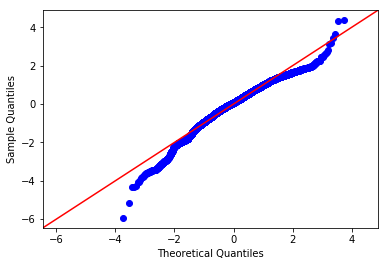

In [54]:
    ax = sm.graphics.qqplot(stud_resid, line='45')

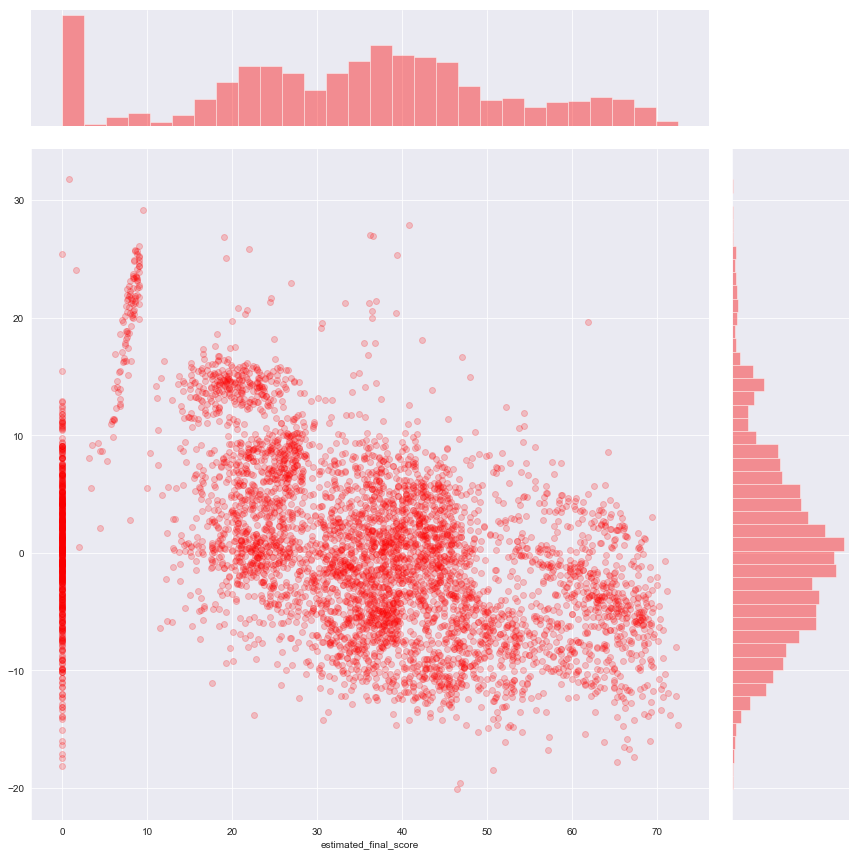

In [59]:
sns.jointplot(x=y_test, y=residuals, height=12, color='r', alpha=0.2)

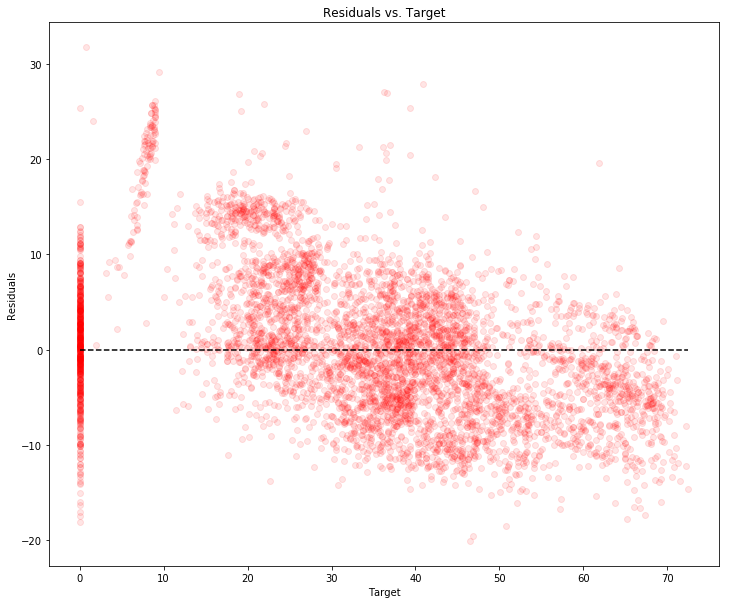

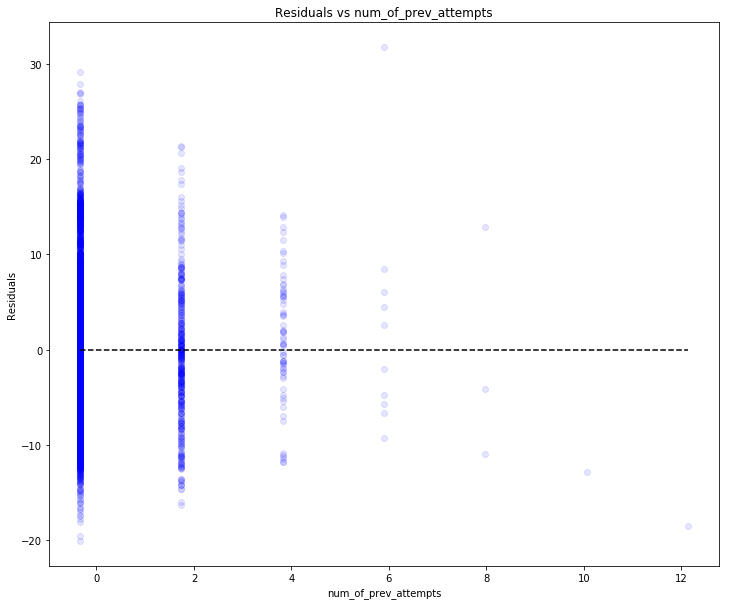

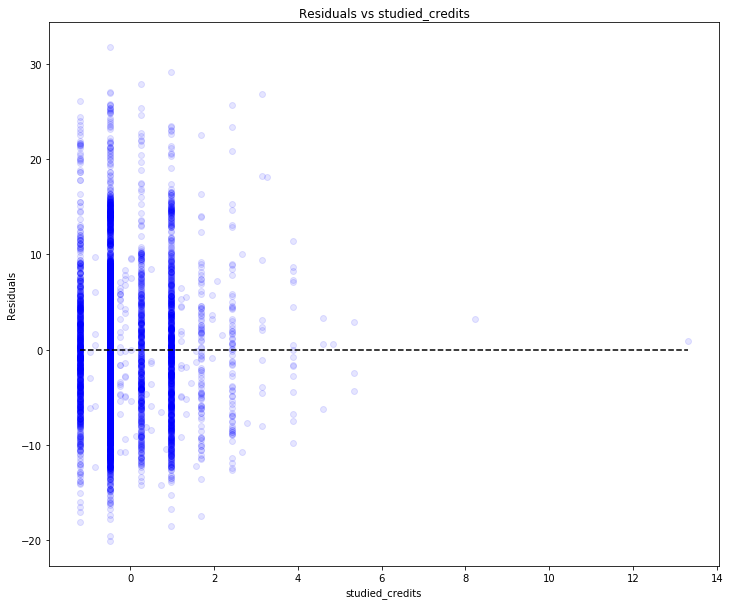

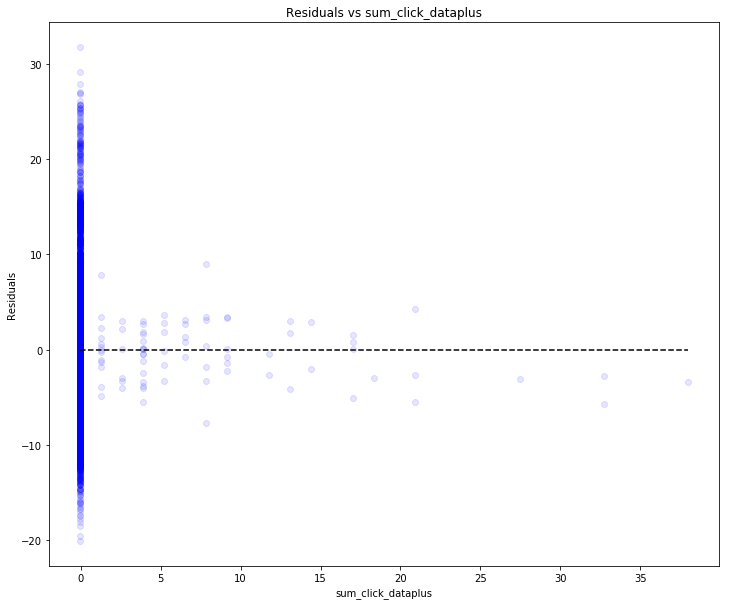

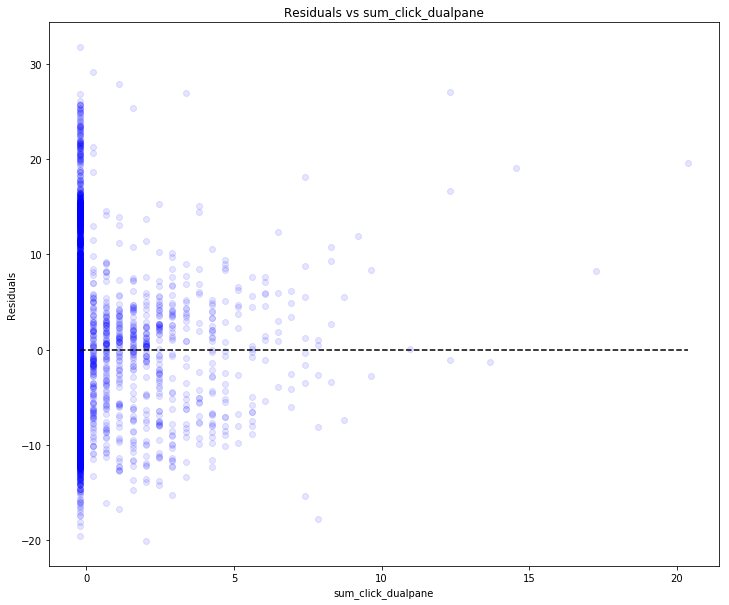

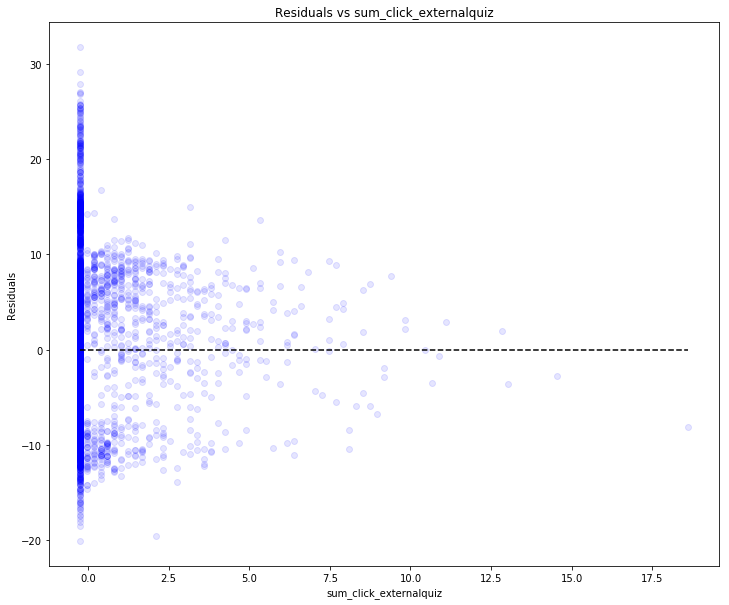

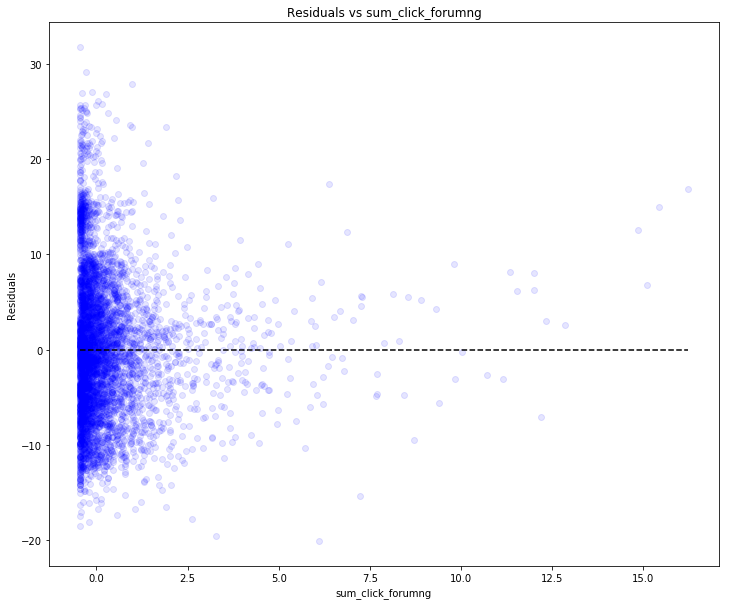

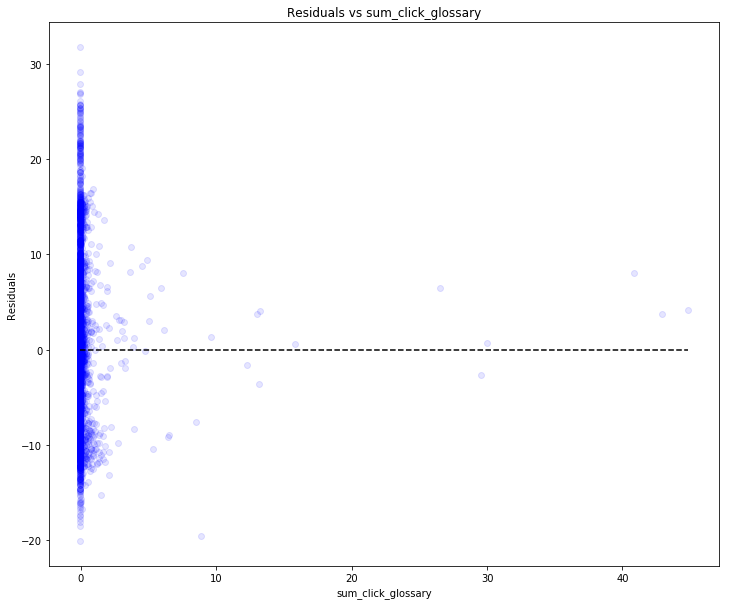

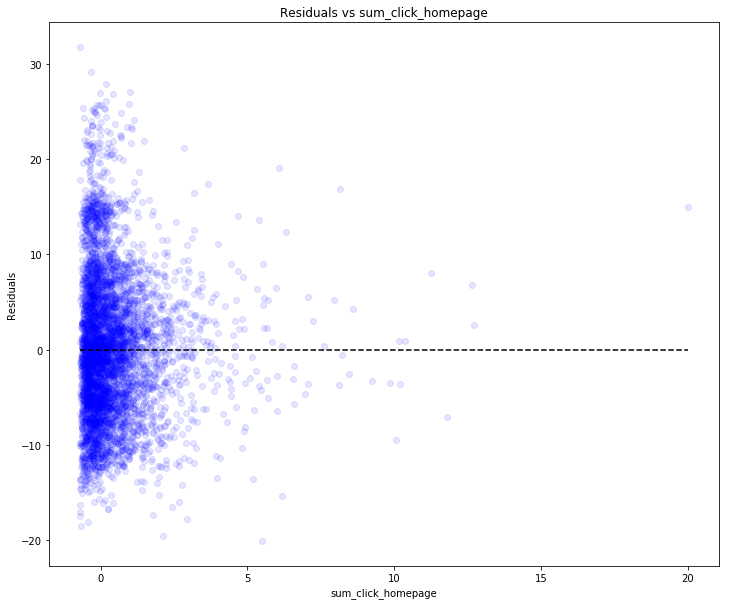

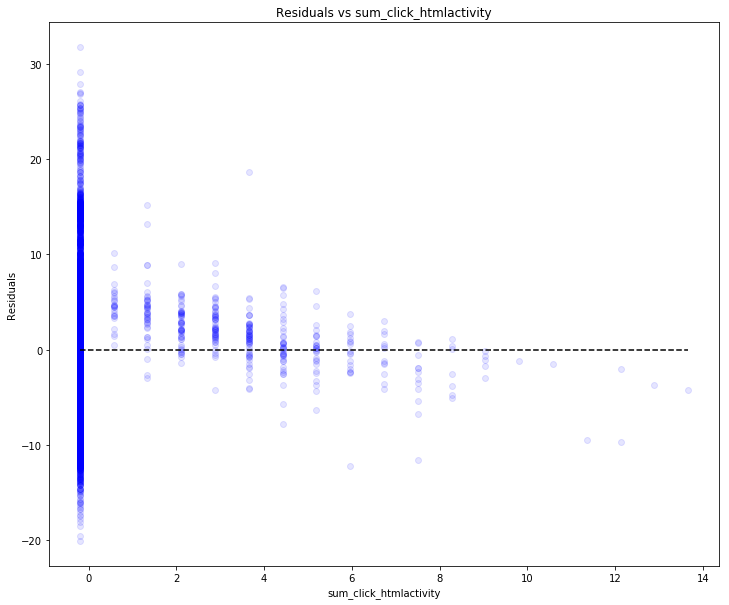

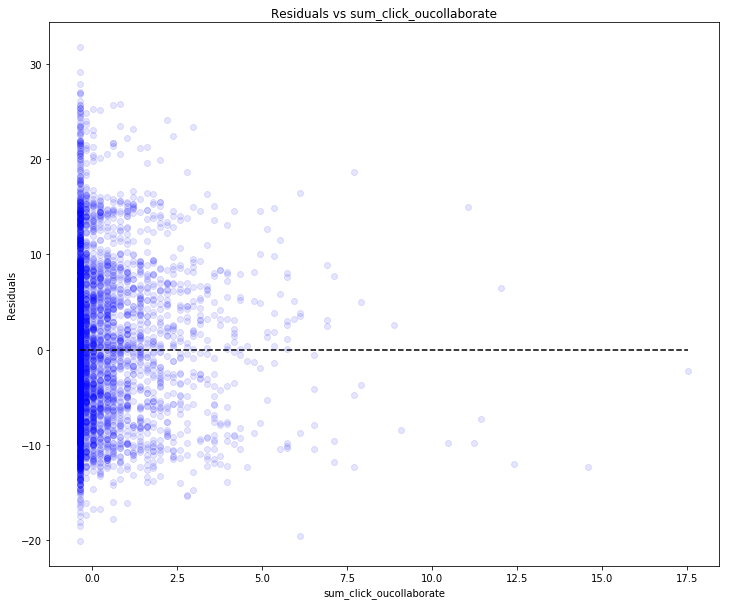

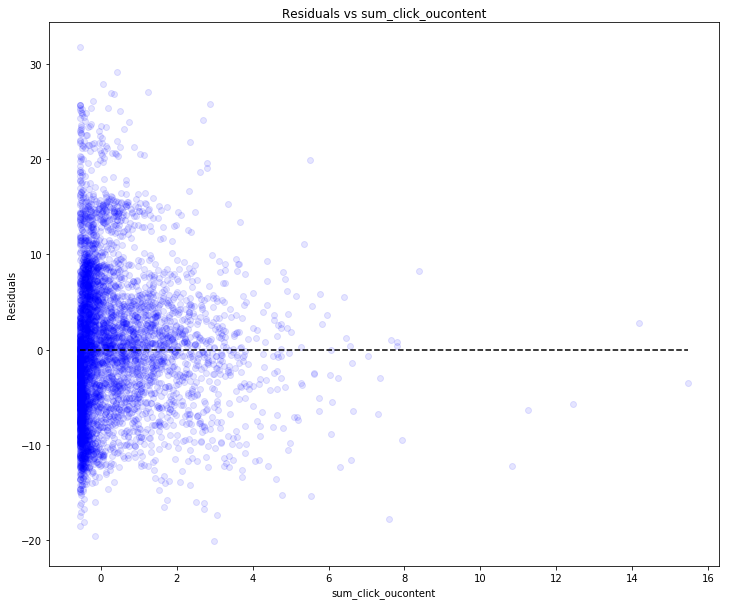

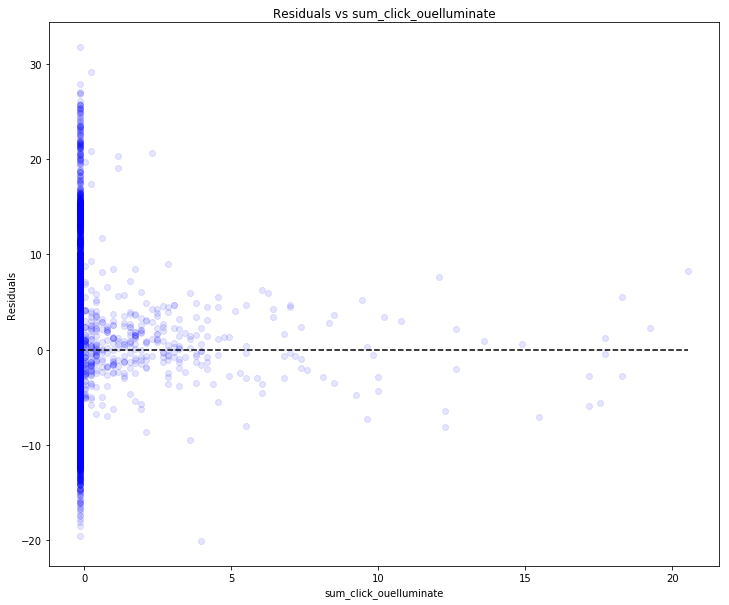

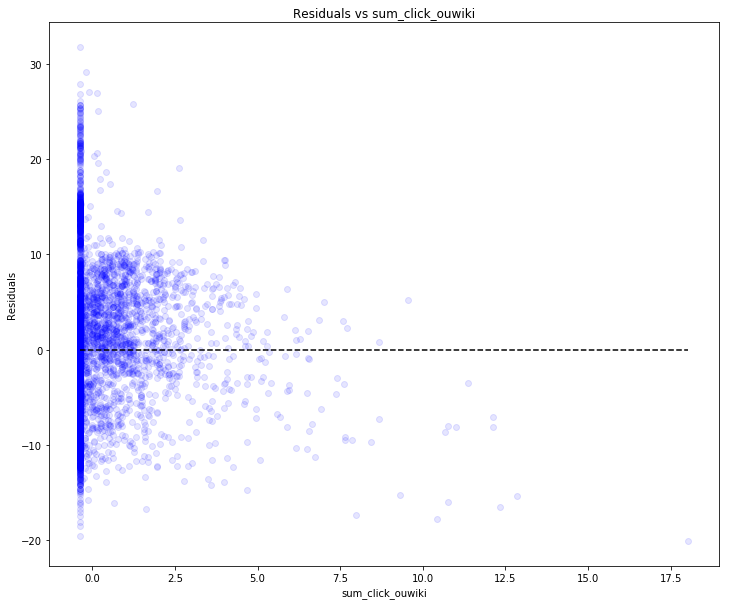

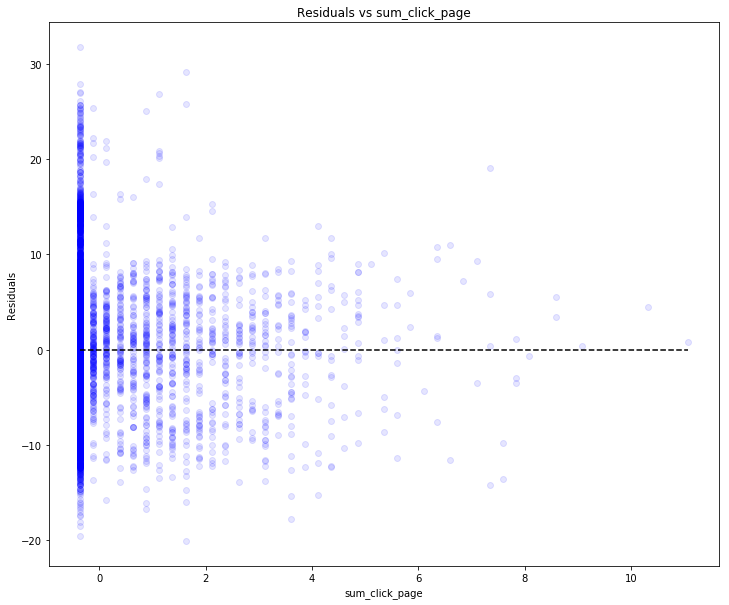

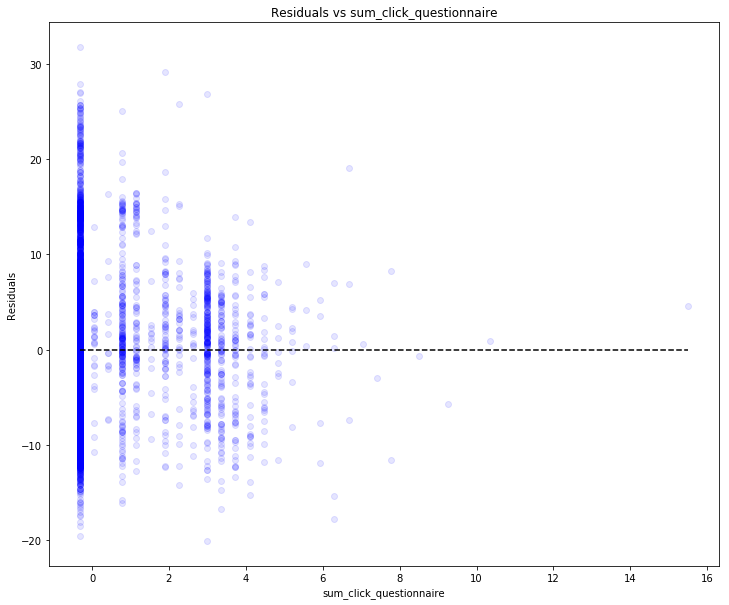

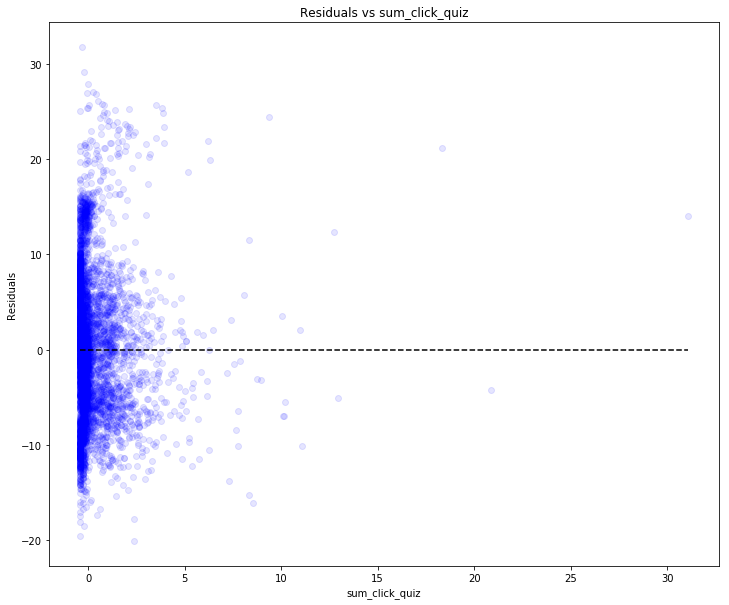

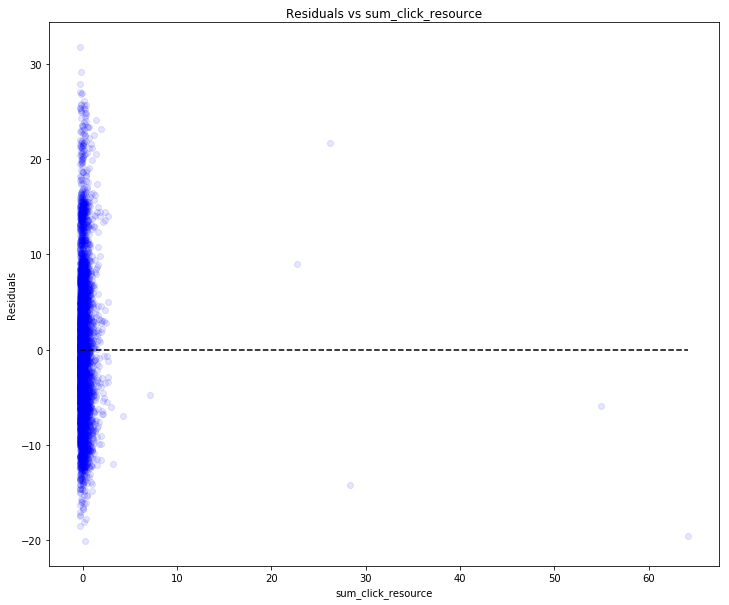

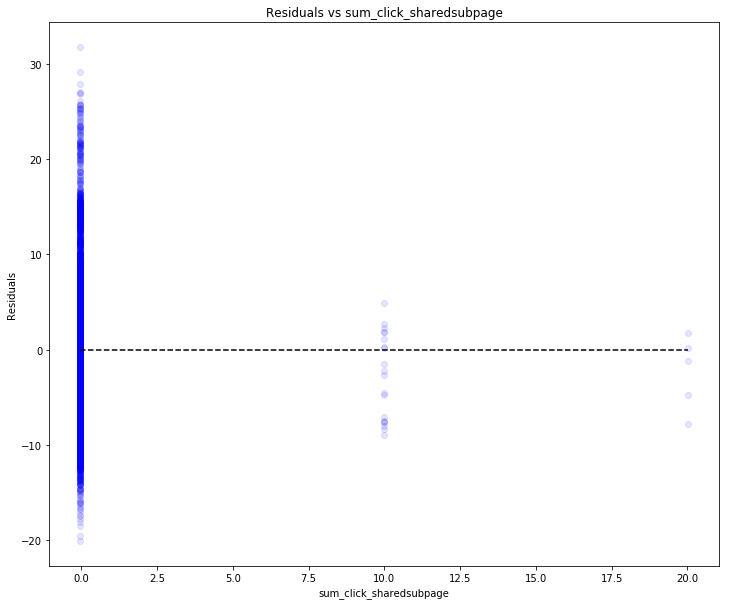

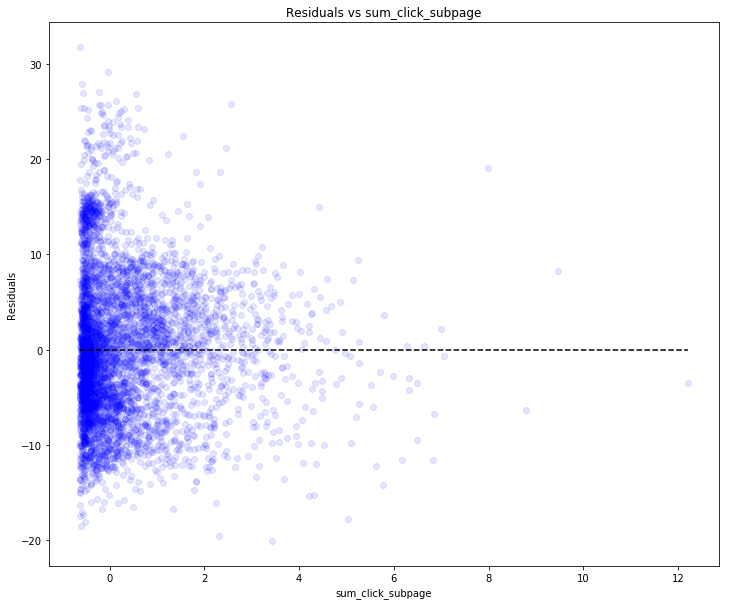

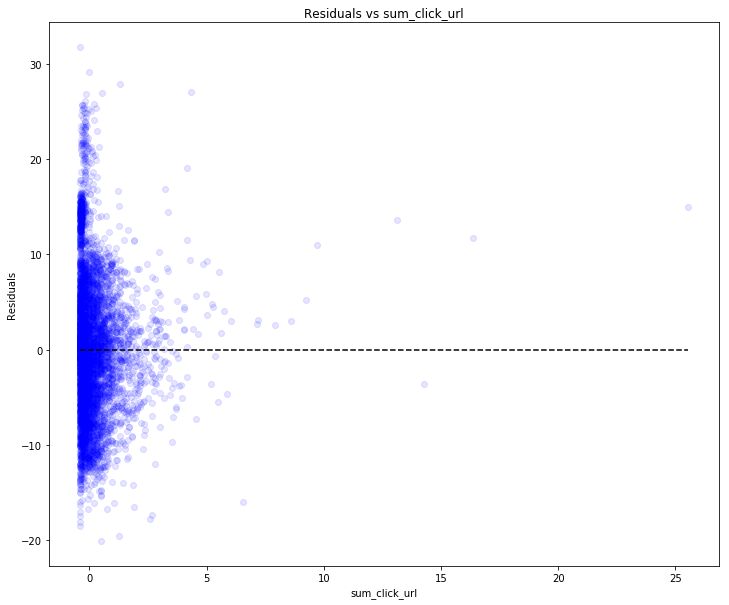

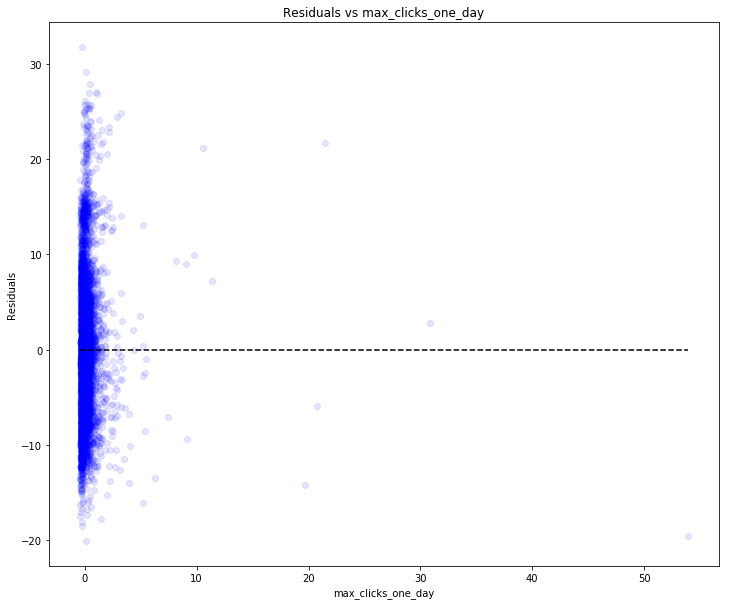

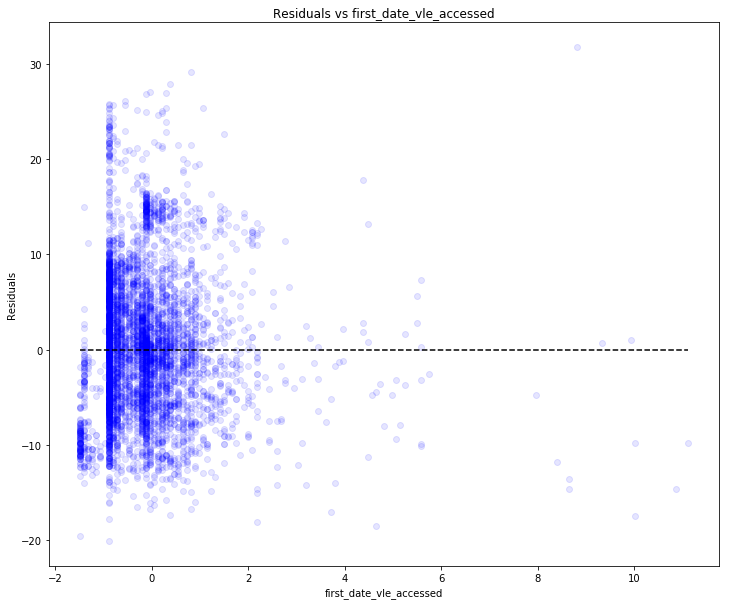

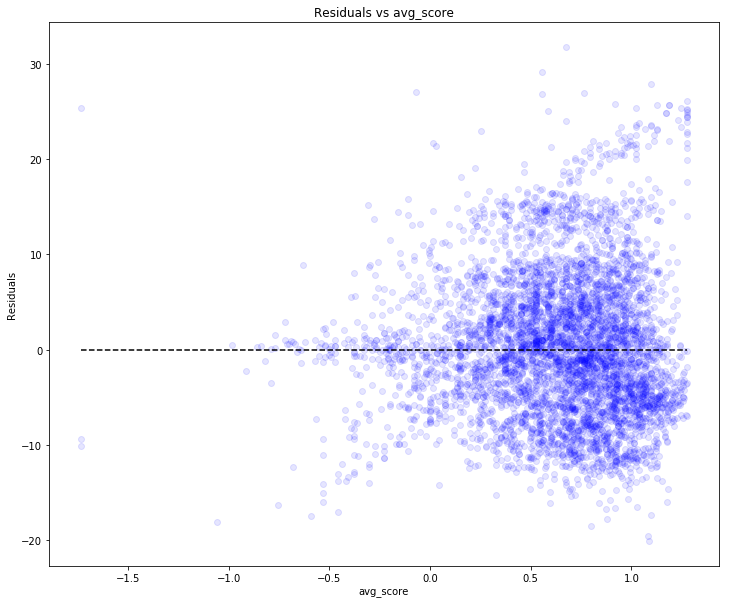

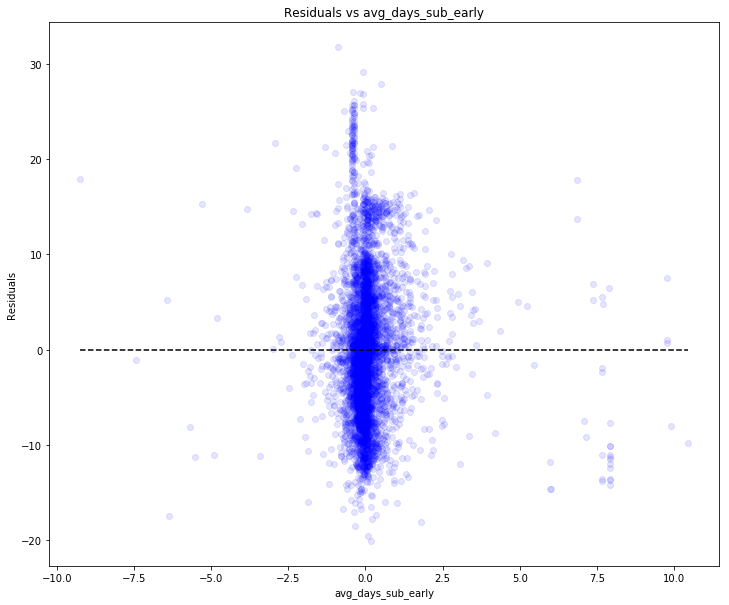

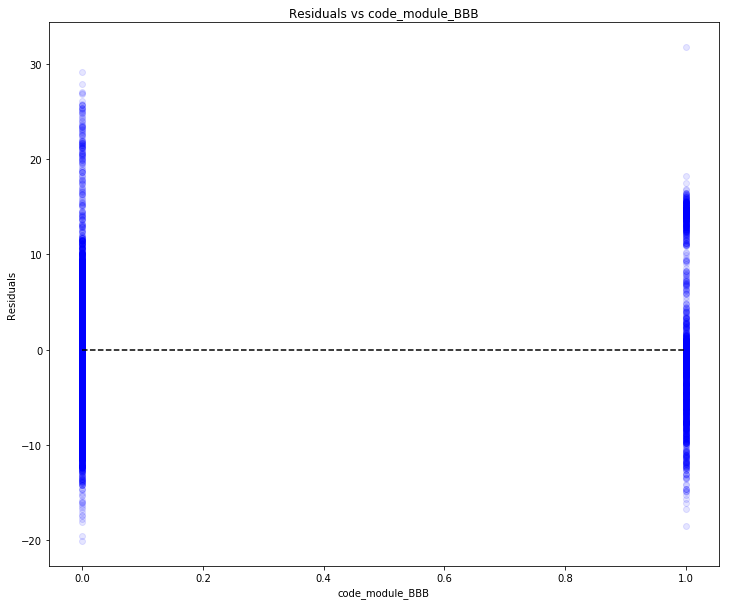

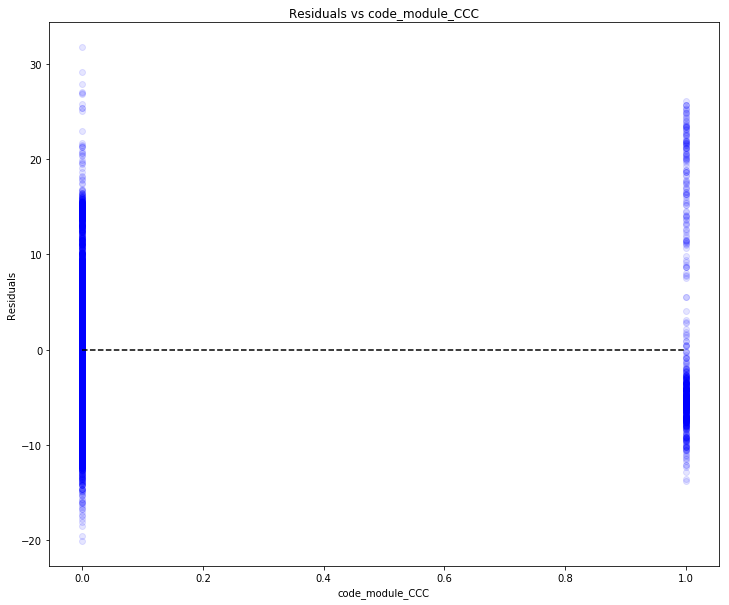

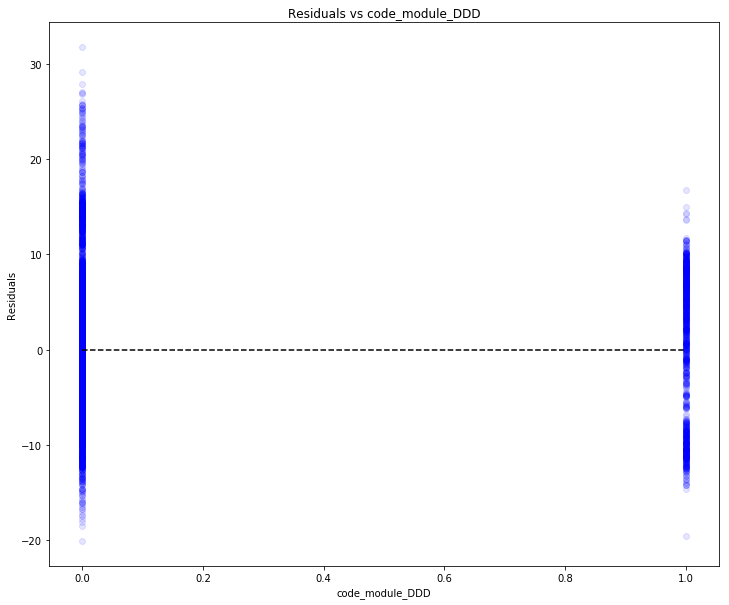

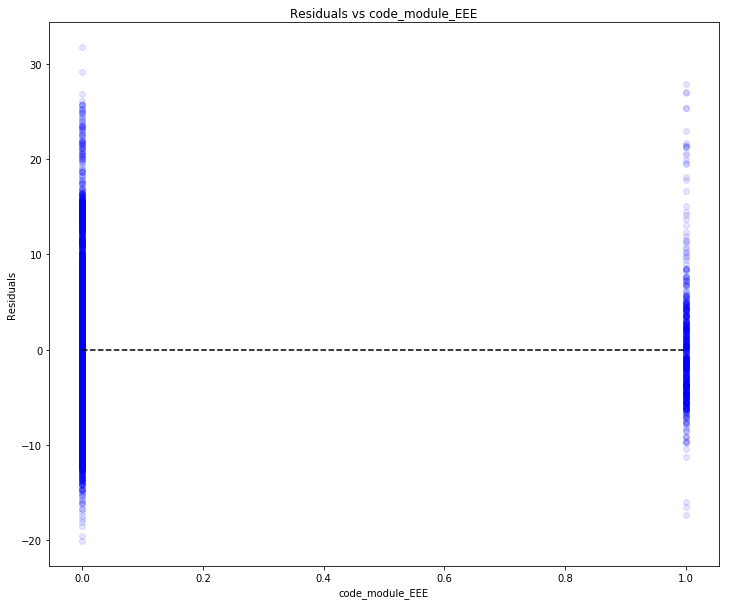

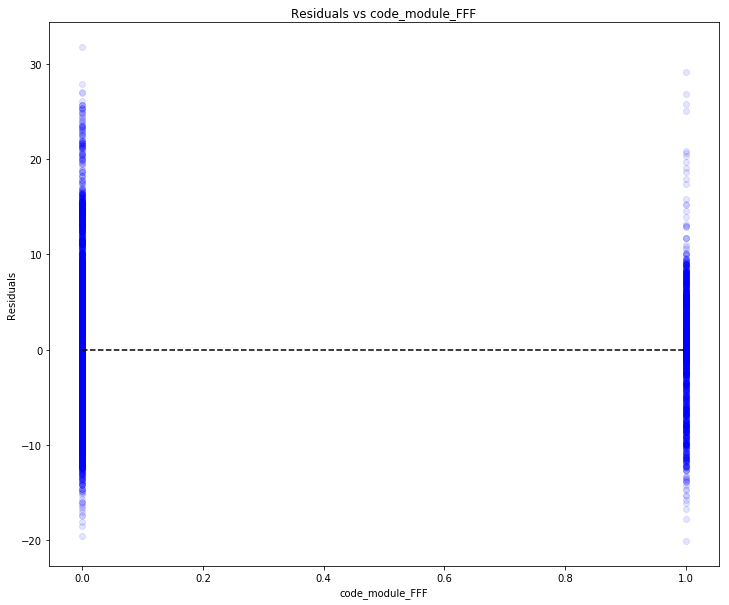

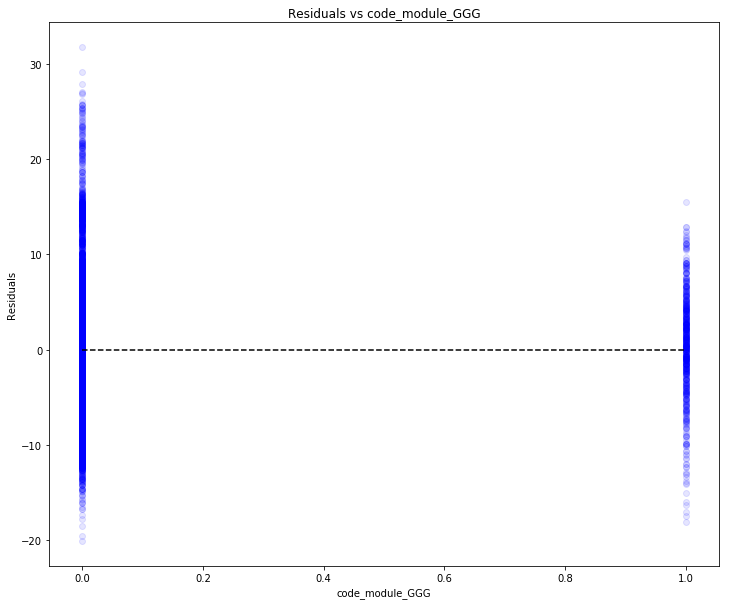

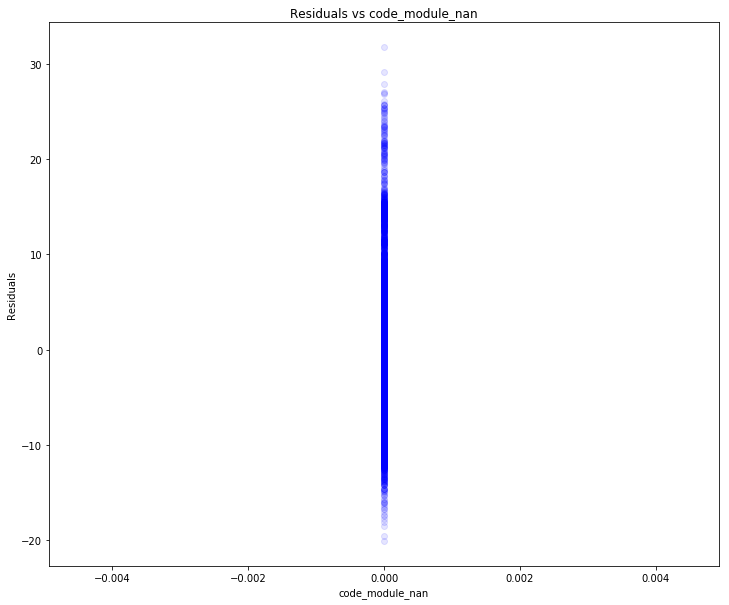

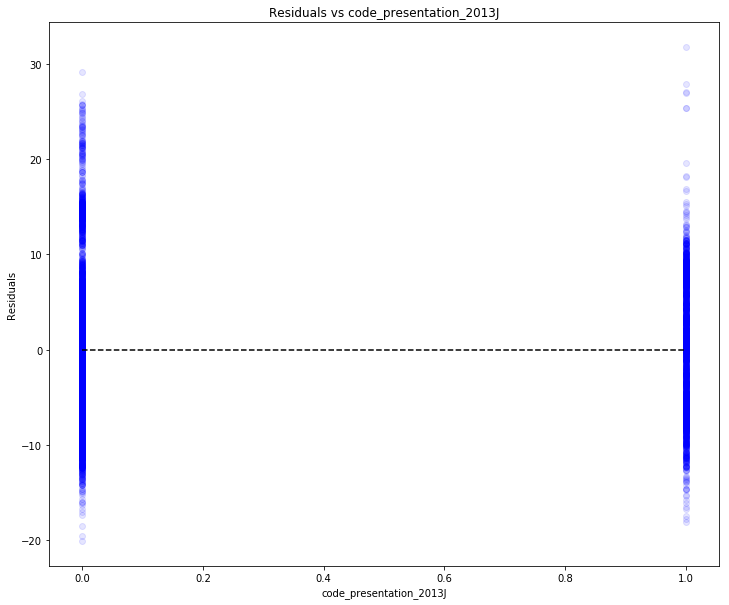

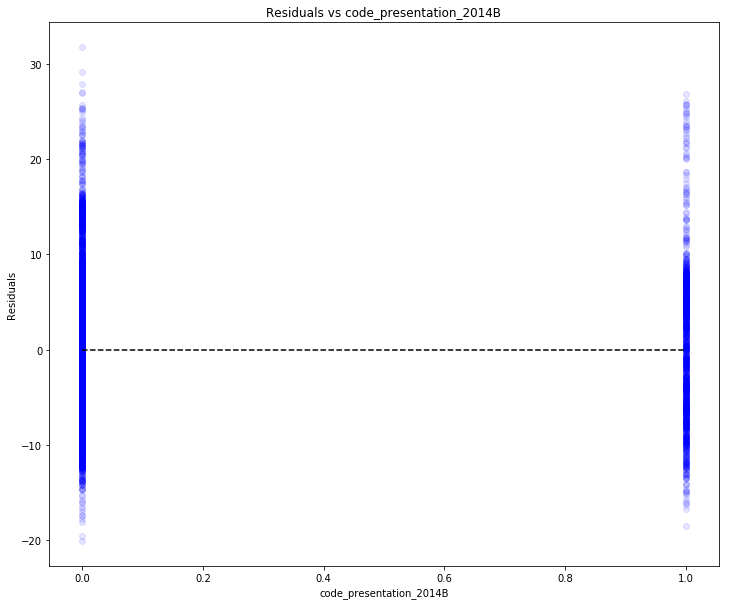

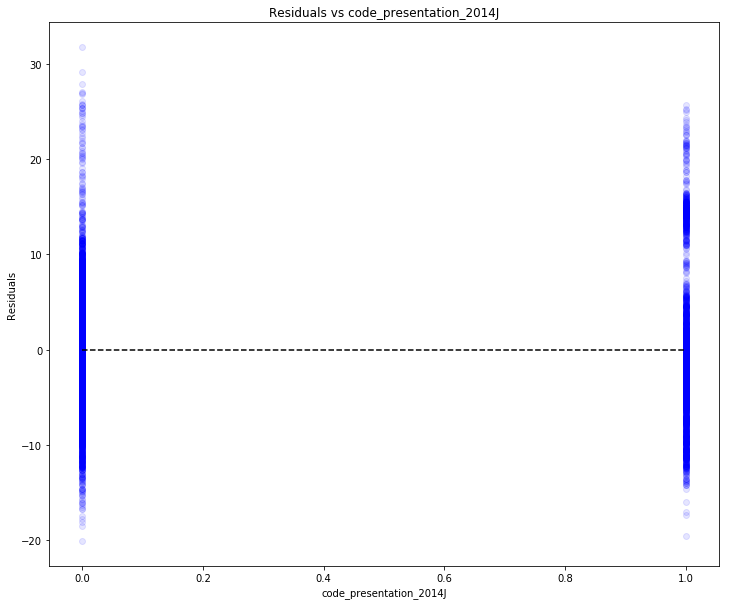

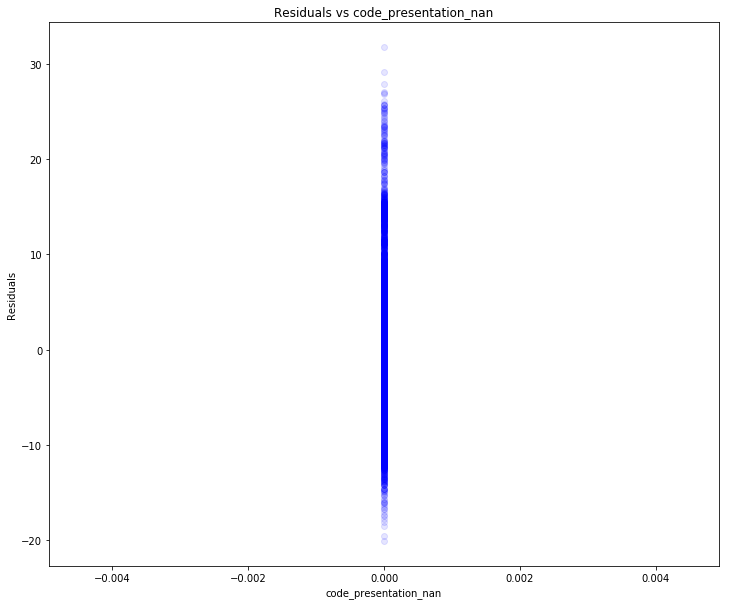

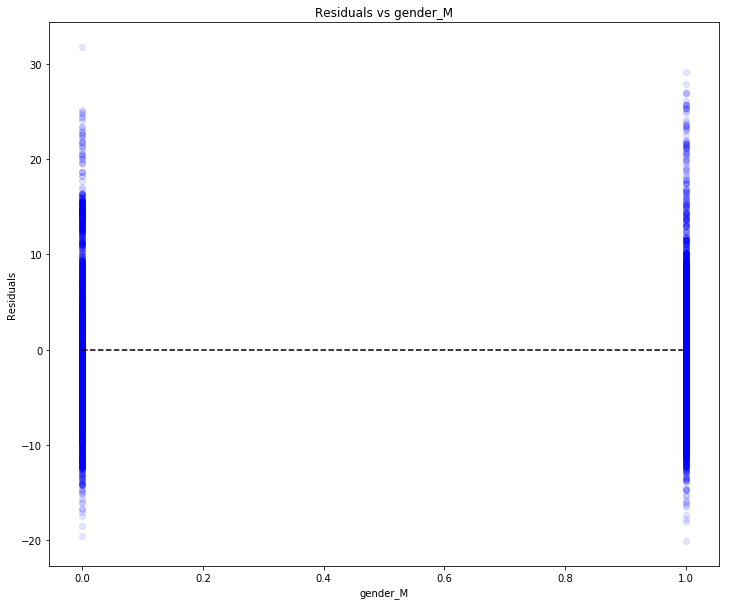

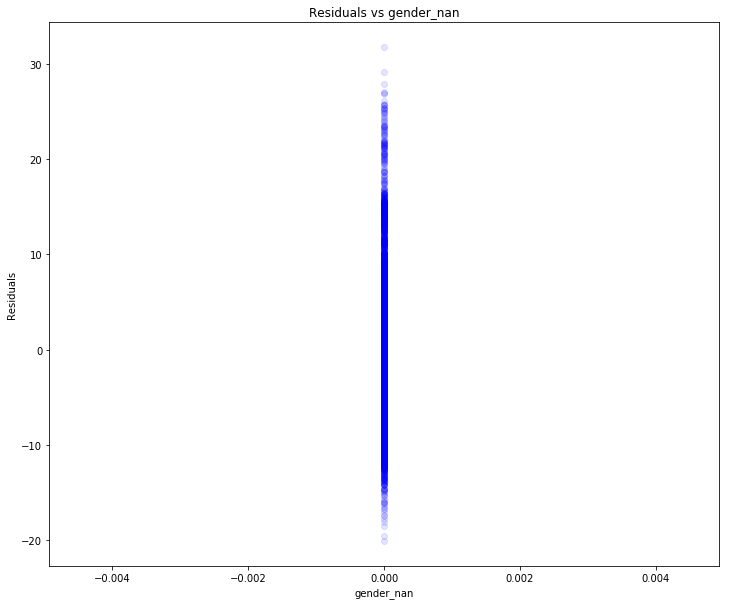

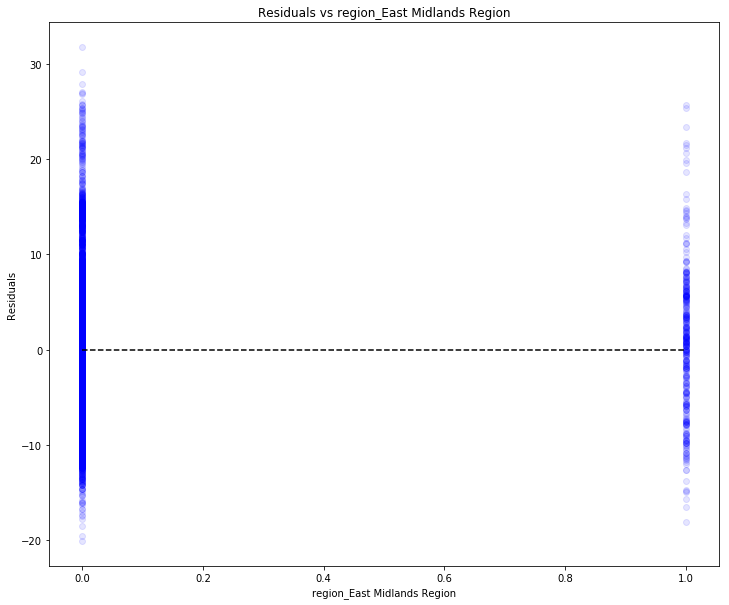

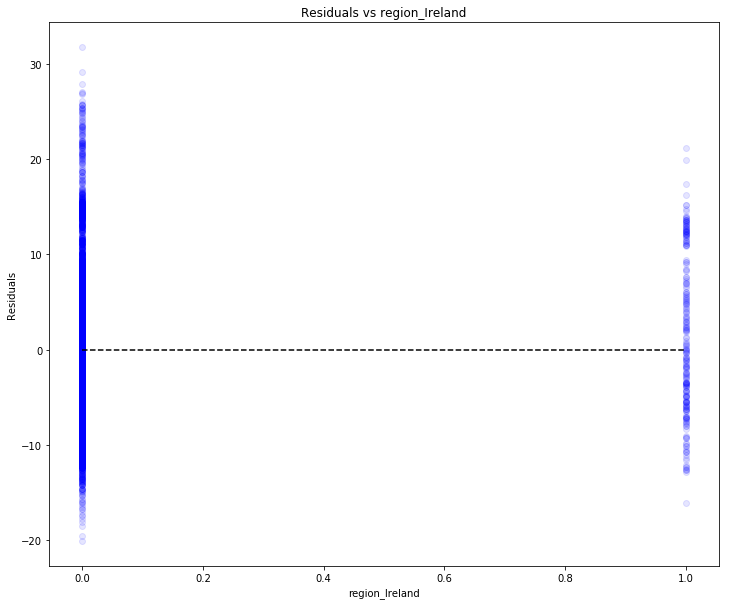

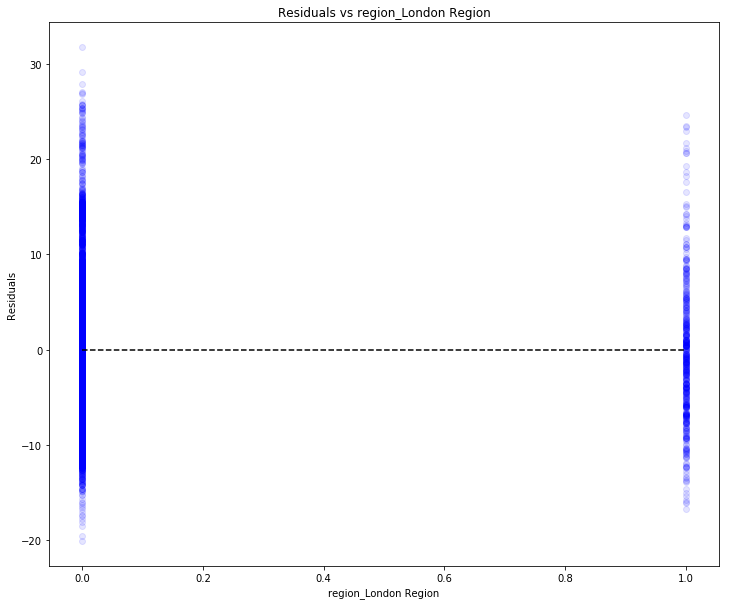

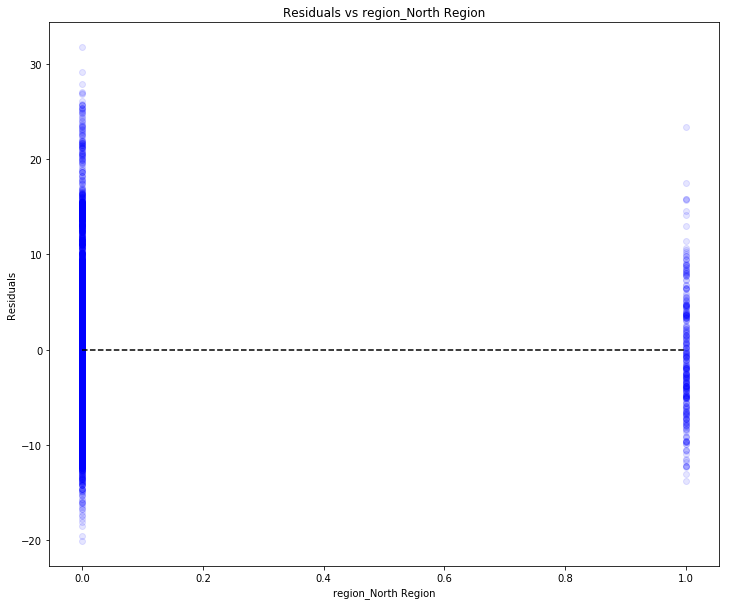

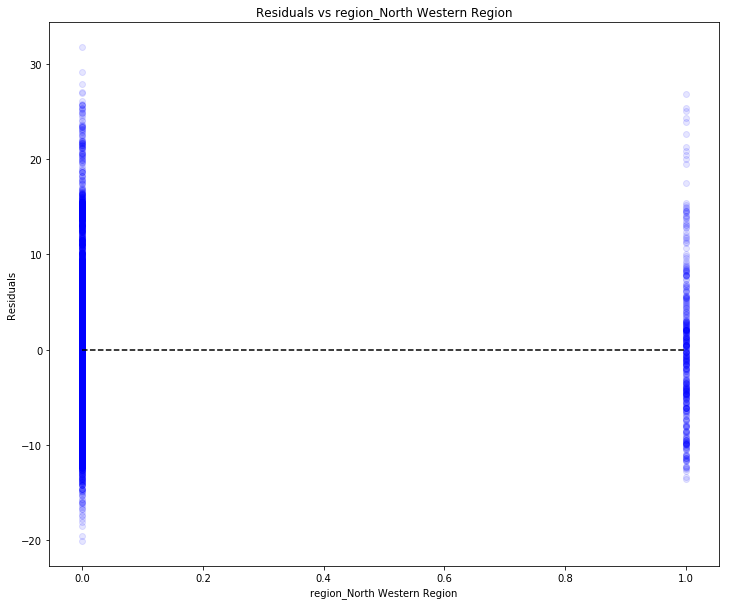

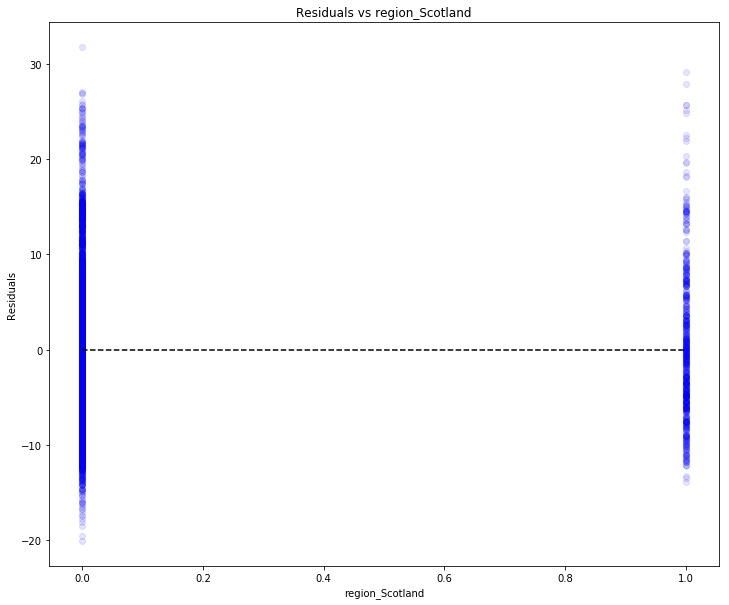

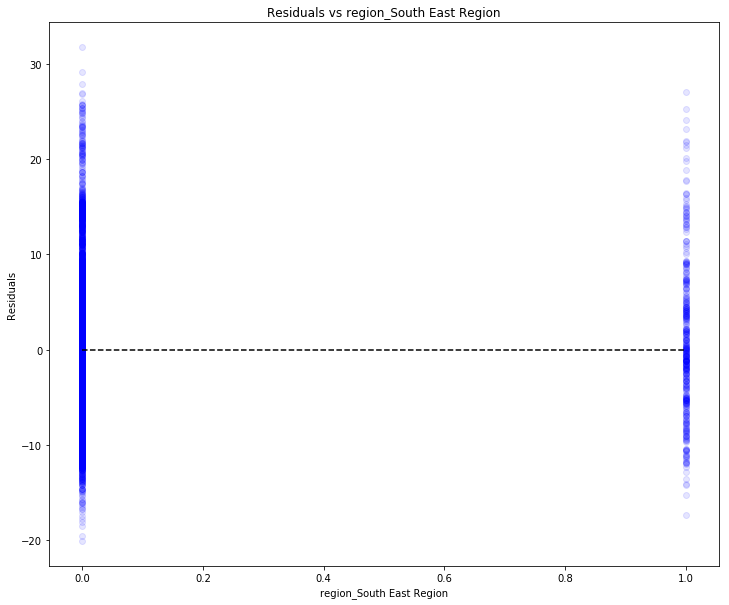

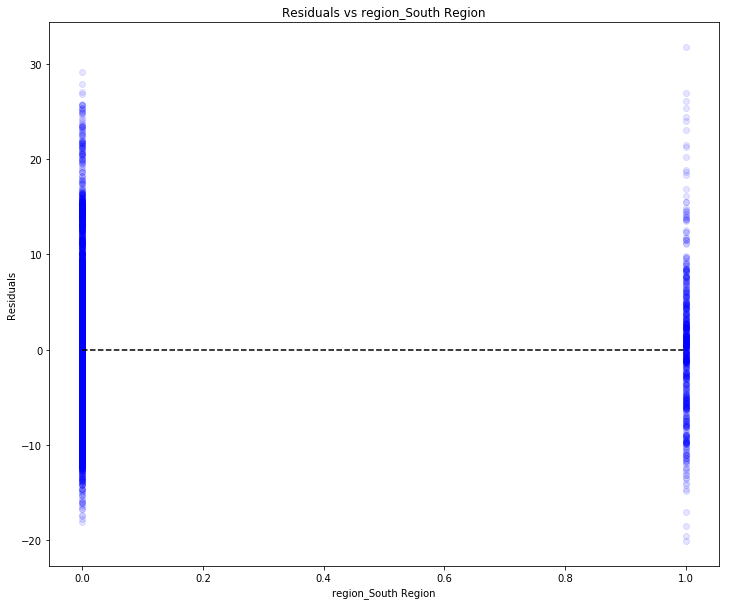

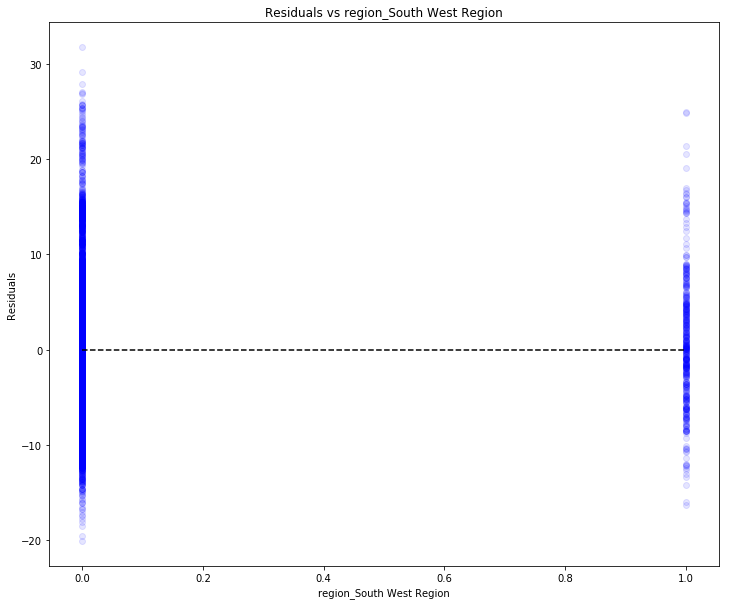

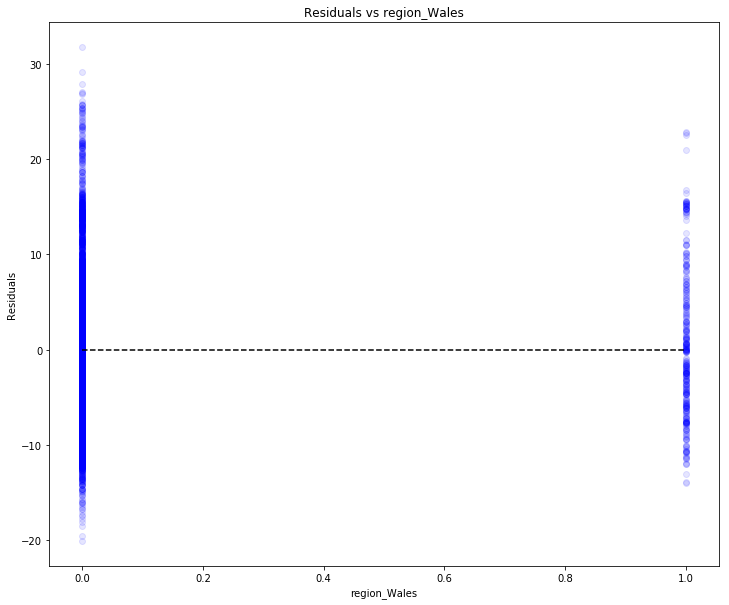

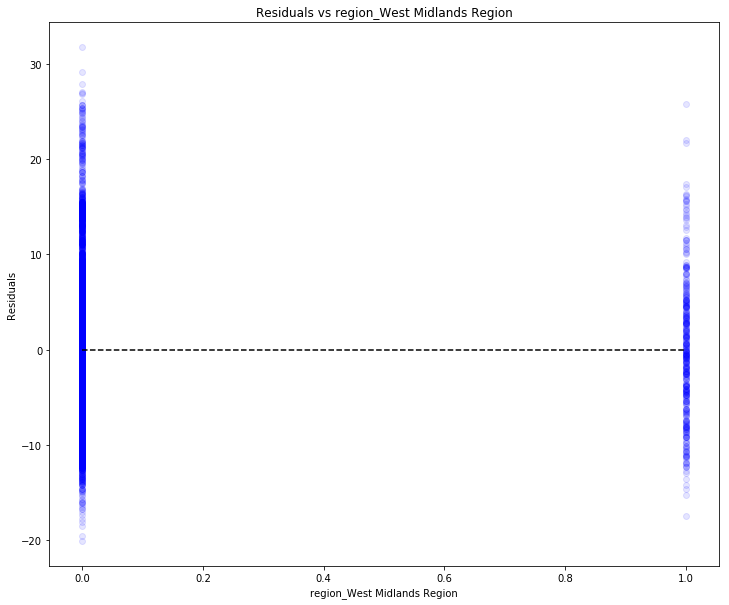

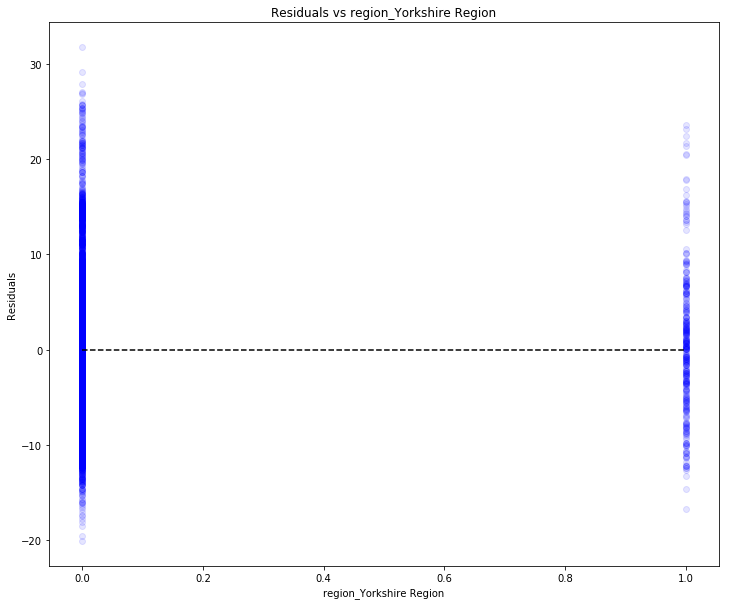

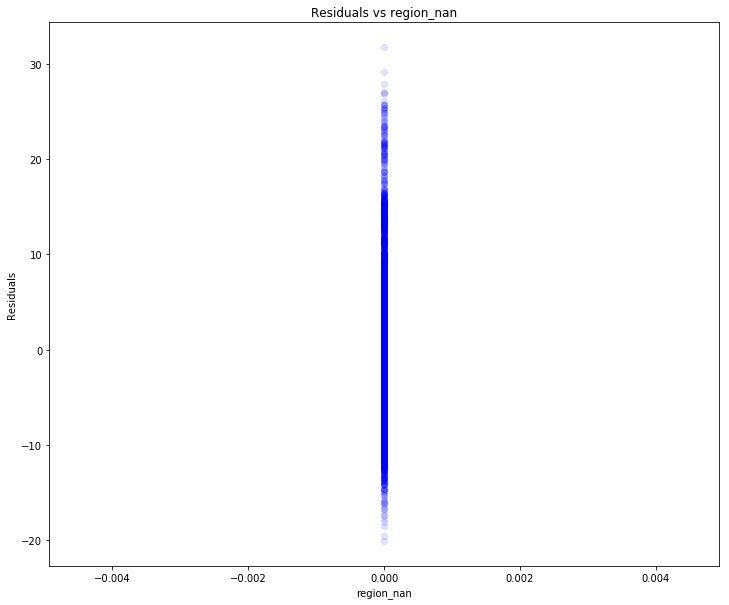

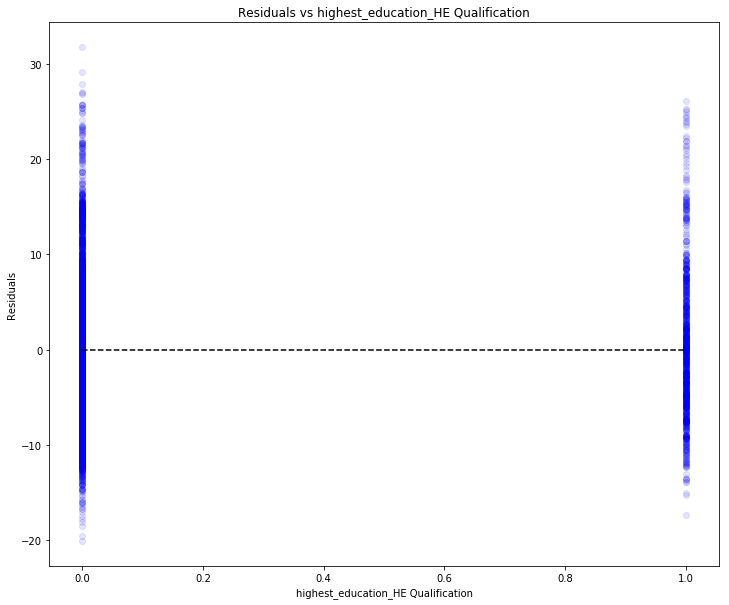

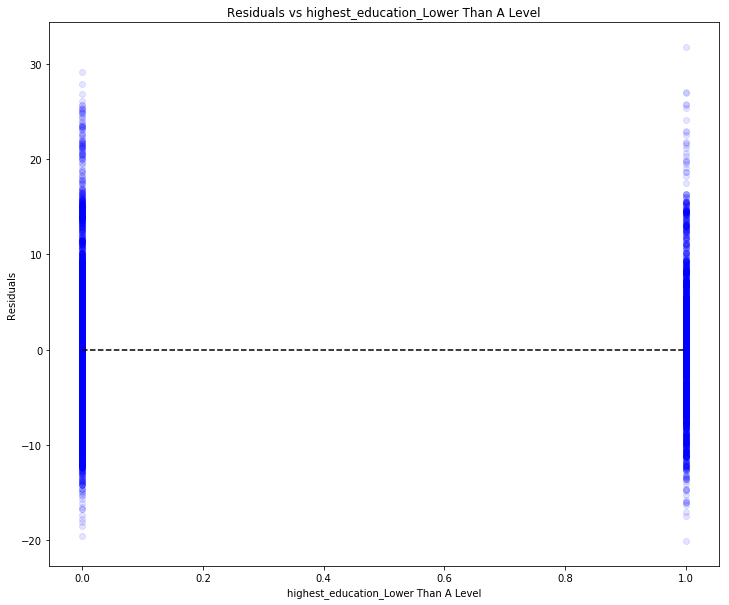

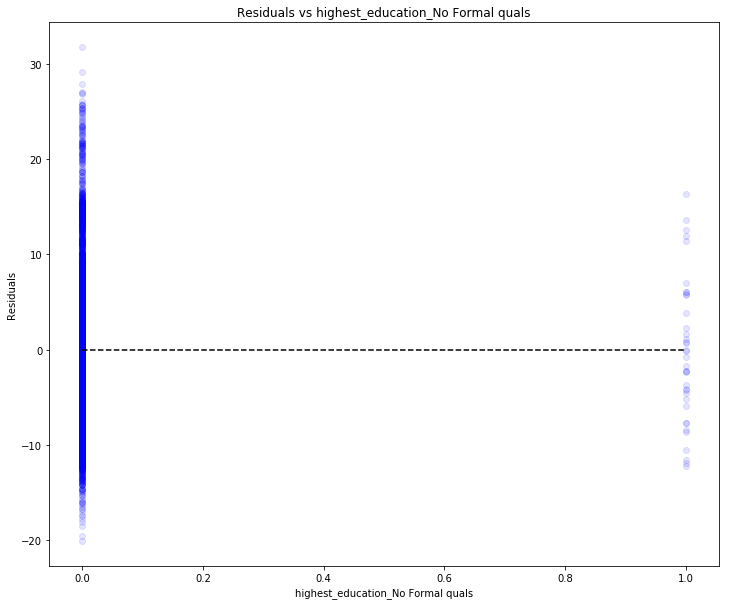

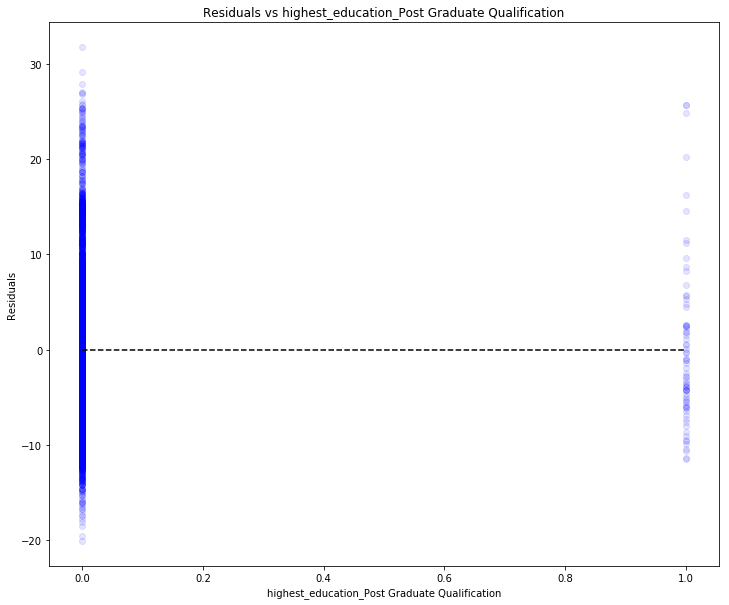

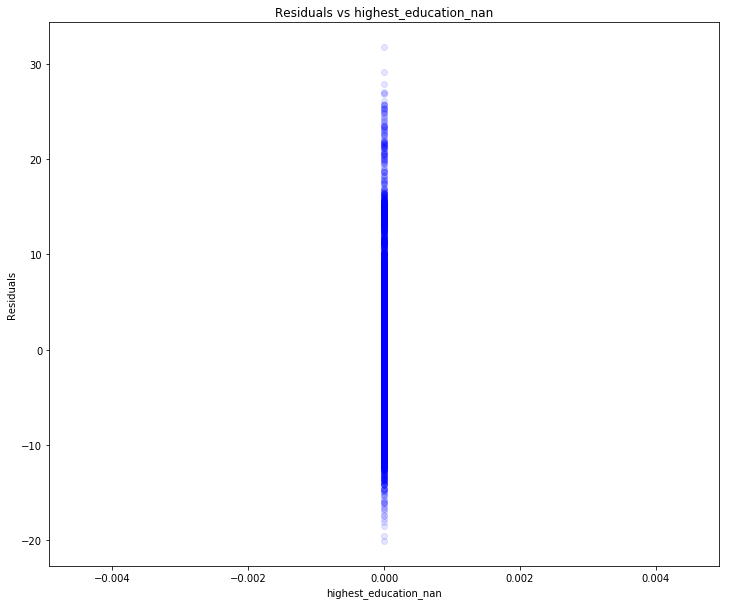

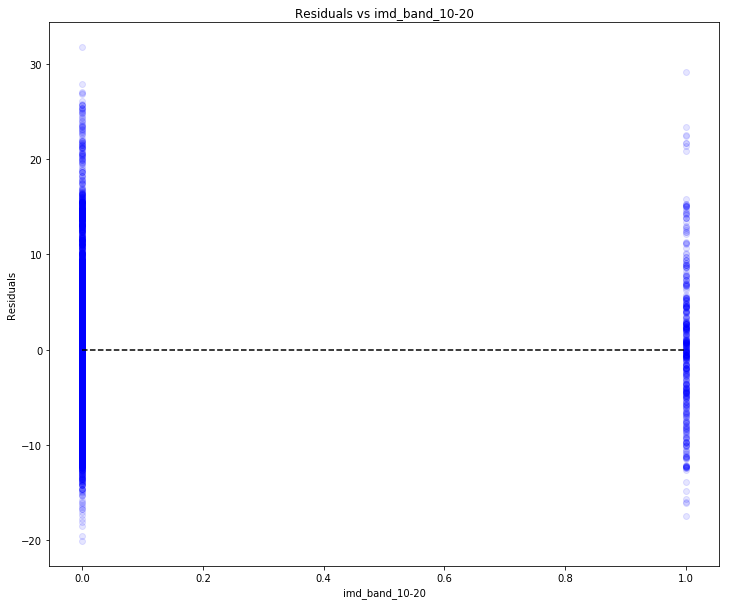

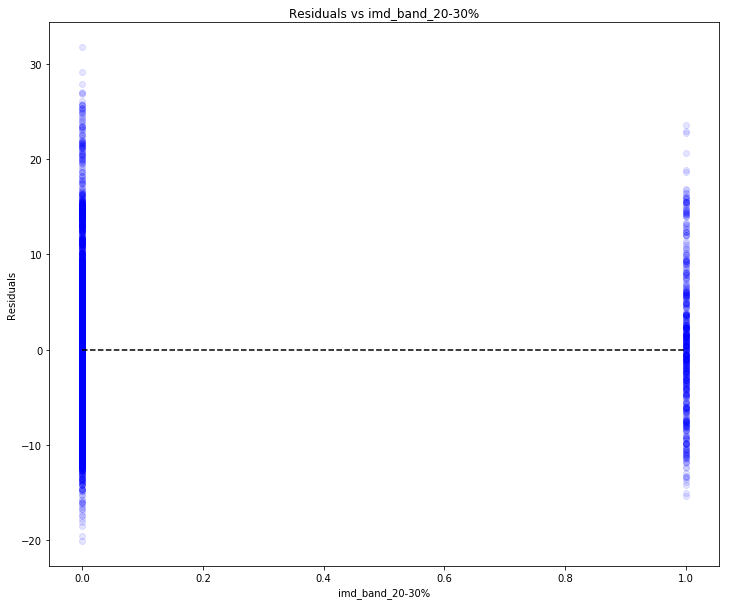

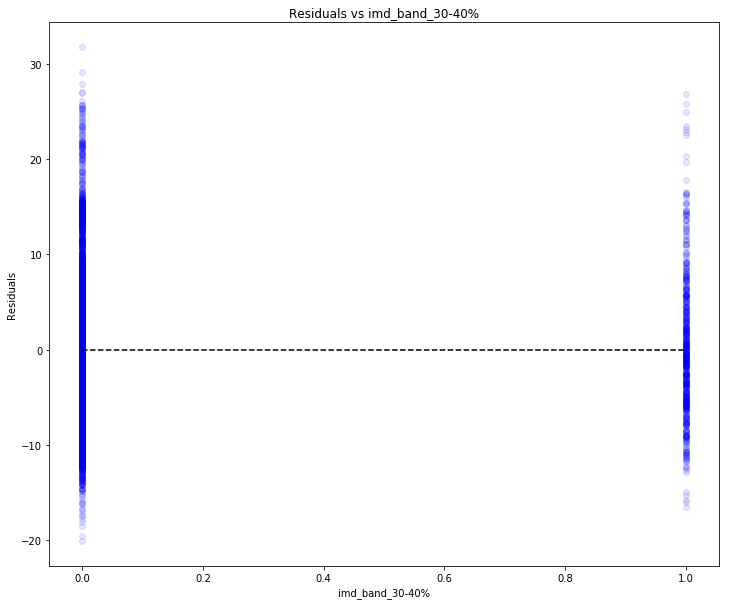

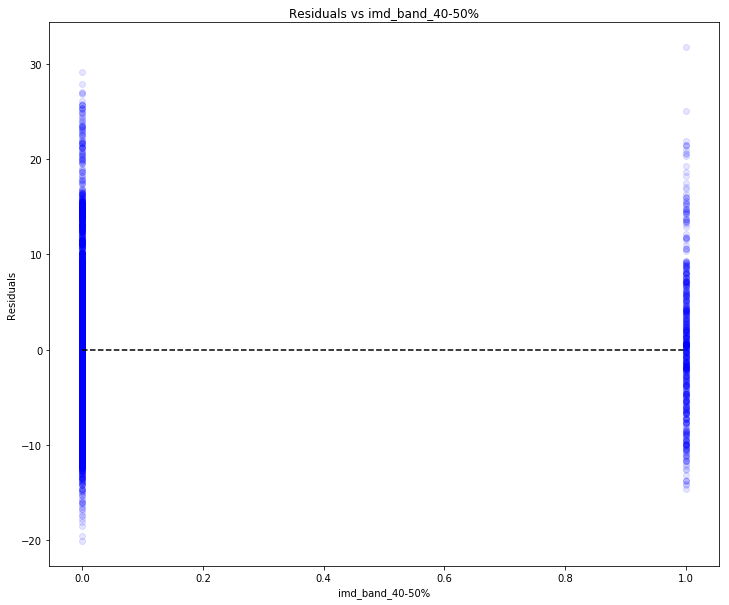

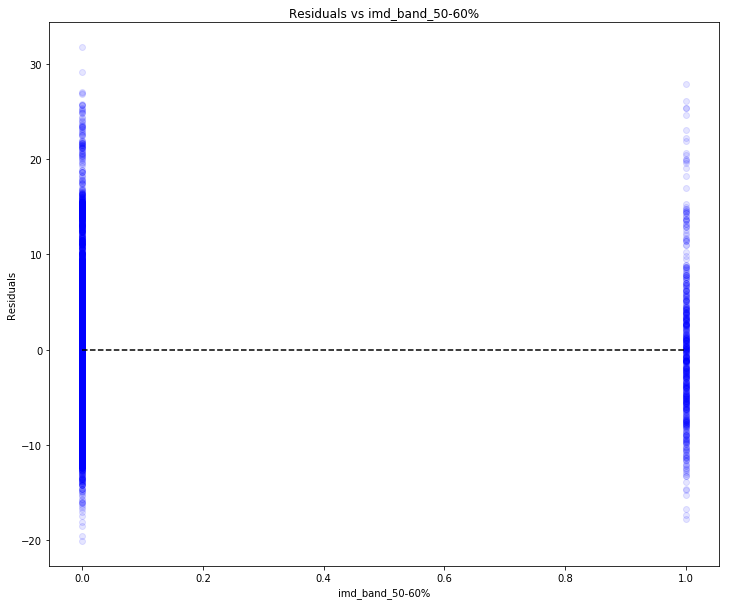

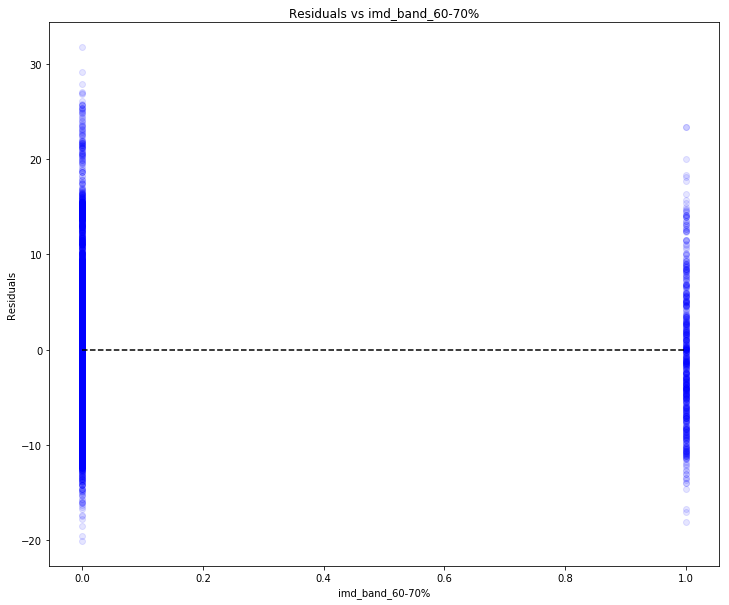

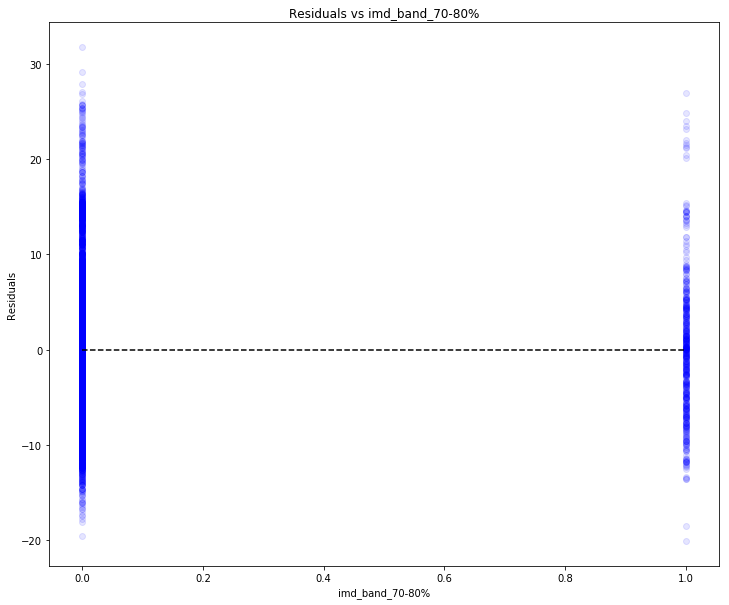

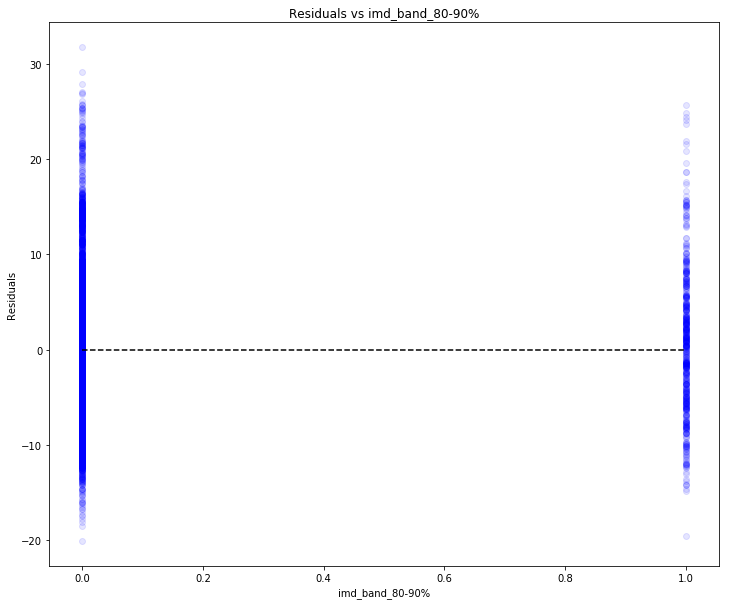

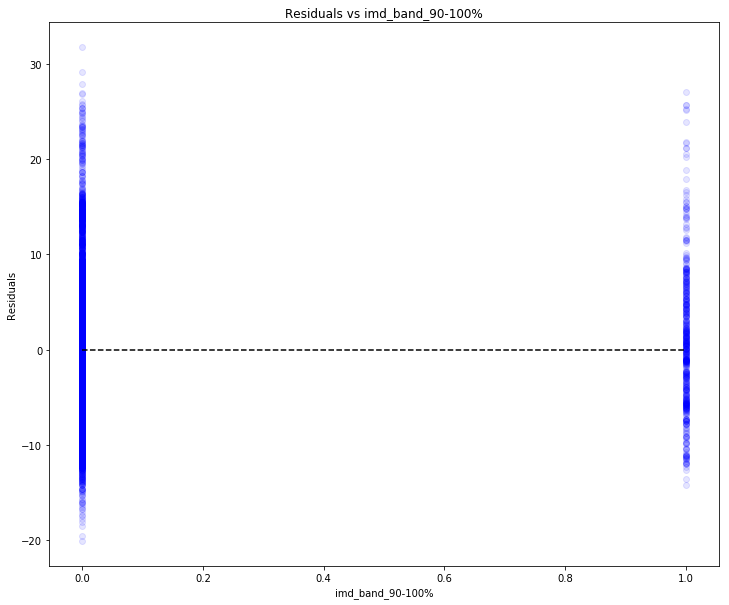

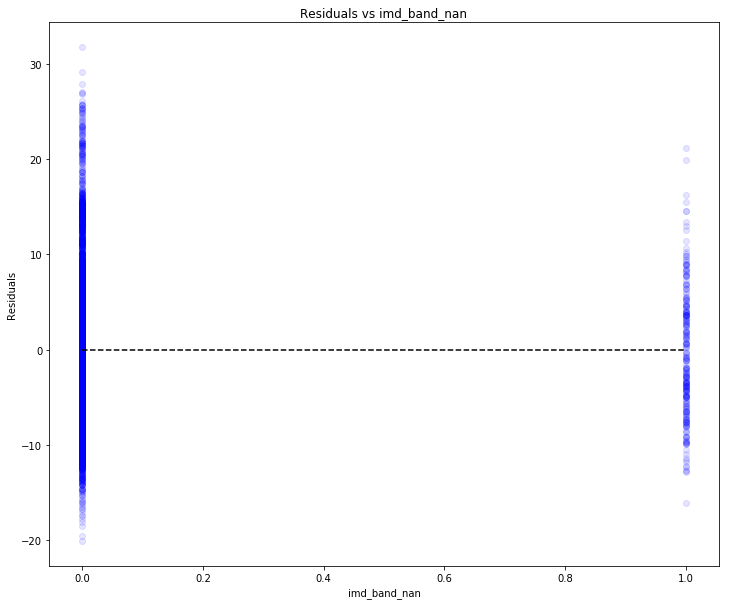

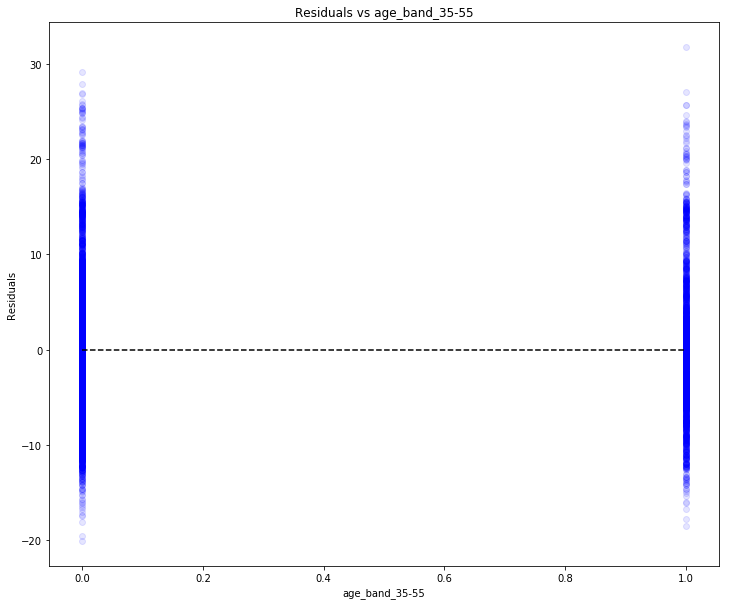

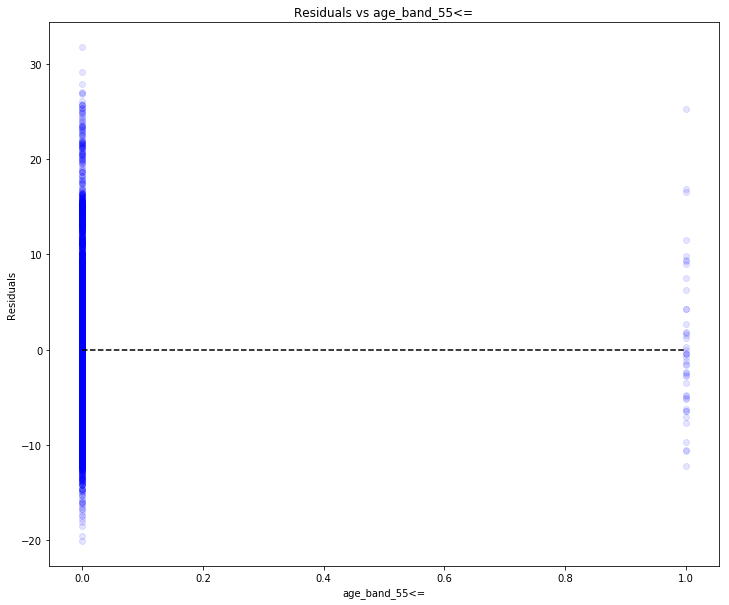

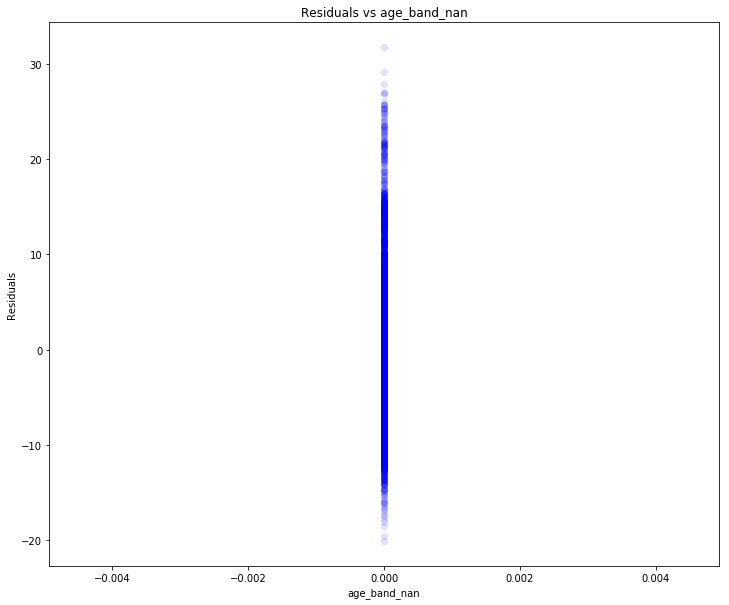

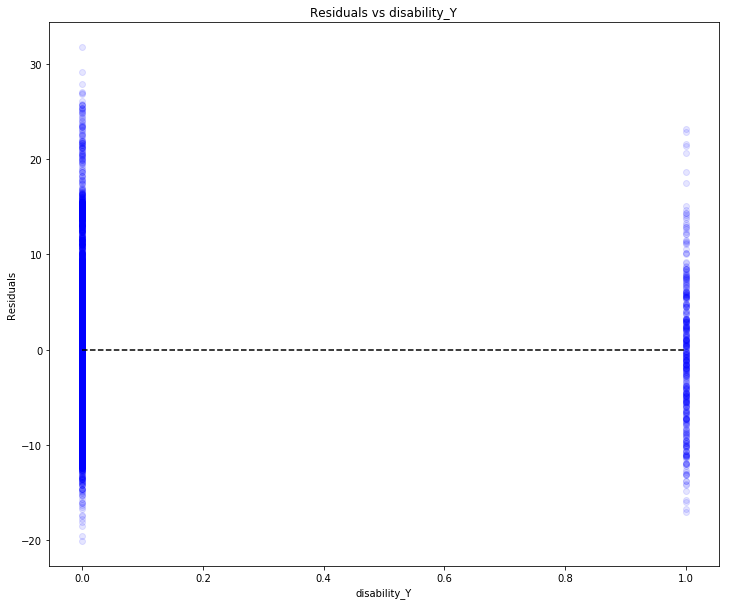

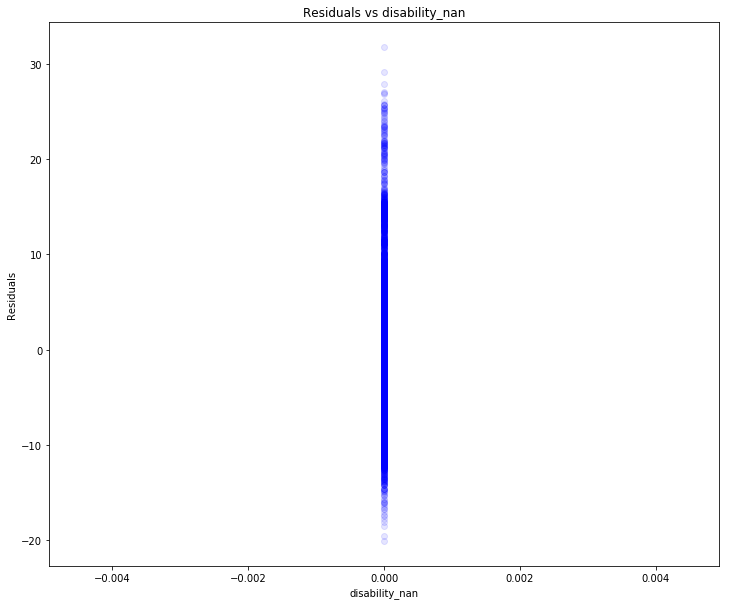

In [44]:
plot_residuals(residuals, y_test, X_test.columns, X_test)